# Summary & Problem Statement
This uses data about electricity generation and meteorological data from 2 solar farms somwhere in India. This project has 3 purposes: <br>


1.   Identify panels that need cleaning or maintenance
2.   Identify faulty euqipments
3.   Predict power output for the next 3 days for better grid management




# Load Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import timeit
from datetime import datetime
from copy import deepcopy
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import metrics
from scipy import stats
from google.colab import drive # this is only required if the code is run on google colab, remove if run on other enviroment
drive.mount('/content/drive') # this is only required if the code is run on google colab, remove if run on other enviroment

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Github/colab-solar

/content/drive/MyDrive/Github/colab-solar


# Load Data & Preprocessing

In [3]:
dfPower2 = pd.read_csv('./Plant_2_Generation_Data.csv', header = 0, engine = 'c')
dfWeather2 = pd.read_csv('./Plant_2_Weather_Sensor_Data.csv', header = 0, engine = 'c')

## Preliminary Data Description

### Data Sanity Check

In [4]:
def check_column_homo(df):
  colNames = df.columns
  sameDtypeList = []
  dtypeCountList = []
  dtypeList = []
  for col in colNames:
    colDtypeCount = len(set(df[col].map(type)))
    if colDtypeCount == 1:
      sameDtype = True
    else:
      sameDtype = False
    dtypes = list(set(df[col].map(type)))
    sameDtypeList.append(sameDtype)
    dtypeCountList.append(colDtypeCount)
    dtypeList.append(dtypes)
  data = {'is_same_dtype': sameDtypeList,
          'dtype_count': dtypeCountList,
          'dtype_list': dtypeList}
  return pd.DataFrame(data, index = colNames)

def replace_space(df):
  result = deepcopy(df)
  colNames = df.columns
  result.loc[:, colNames] = result.loc[:, colNames].replace (r'^\s+', np.nan, regex=True)
  return result


In [5]:
check_column_homo(dfPower2)

,is_same_dtype,dtype_count,dtype_list
DATE_TIME,True,1,[<class 'str'>]
PLANT_ID,True,1,[<class 'int'>]
SOURCE_KEY,True,1,[<class 'str'>]
DC_POWER,True,1,[<class 'float'>]
AC_POWER,True,1,[<class 'float'>]
DAILY_YIELD,True,1,[<class 'float'>]
TOTAL_YIELD,True,1,[<class 'float'>]


In [6]:
check_column_homo(dfWeather2)

,is_same_dtype,dtype_count,dtype_list
DATE_TIME,True,1,[<class 'str'>]
PLANT_ID,True,1,[<class 'int'>]
SOURCE_KEY,True,1,[<class 'str'>]
AMBIENT_TEMPERATURE,True,1,[<class 'float'>]
MODULE_TEMPERATURE,True,1,[<class 'float'>]
IRRADIATION,True,1,[<class 'float'>]


#### Check Null Values & Empty Space
From the be below tests, there are no nulls/missing values in the dataset.



In [7]:
dfPower2 = replace_space(dfPower2)
dfWeather2 = replace_space(dfWeather2)

In [8]:
dfPower2.DATE_TIME = dfPower2.DATE_TIME.astype('datetime64[ns]')
dfWeather2.DATE_TIME = dfWeather2.DATE_TIME.astype('datetime64[ns]')

In [9]:
dfPower2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67698 entries, 0 to 67697
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATE_TIME    67698 non-null  datetime64[ns]
 1   PLANT_ID     67698 non-null  int64         
 2   SOURCE_KEY   67698 non-null  object        
 3   DC_POWER     67698 non-null  float64       
 4   AC_POWER     67698 non-null  float64       
 5   DAILY_YIELD  67698 non-null  float64       
 6   TOTAL_YIELD  67698 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 3.6+ MB


In [10]:
dfPower2.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,2020-05-15,4136001,4UPUqMRk7TRMgml,0.0,0.0,9425.000000,2.429011e+06
1,2020-05-15,4136001,81aHJ1q11NBPMrL,0.0,0.0,0.000000,1.215279e+09
2,2020-05-15,4136001,9kRcWv60rDACzjR,0.0,0.0,3075.333333,2.247720e+09
3,2020-05-15,4136001,Et9kgGMDl729KT4,0.0,0.0,269.933333,1.704250e+06
4,2020-05-15,4136001,IQ2d7wF4YD8zU1Q,0.0,0.0,3177.000000,1.994153e+07


In [11]:
dfWeather2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3259 entries, 0 to 3258
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            3259 non-null   datetime64[ns]
 1   PLANT_ID             3259 non-null   int64         
 2   SOURCE_KEY           3259 non-null   object        
 3   AMBIENT_TEMPERATURE  3259 non-null   float64       
 4   MODULE_TEMPERATURE   3259 non-null   float64       
 5   IRRADIATION          3259 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 152.9+ KB


In [12]:
dfWeather2.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4136001,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0
1,2020-05-15 00:15:00,4136001,iq8k7ZNt4Mwm3w0,26.880811,24.421869,0.0
2,2020-05-15 00:30:00,4136001,iq8k7ZNt4Mwm3w0,26.682055,24.427290,0.0
3,2020-05-15 00:45:00,4136001,iq8k7ZNt4Mwm3w0,26.500589,24.420678,0.0
4,2020-05-15 01:00:00,4136001,iq8k7ZNt4Mwm3w0,26.596148,25.088210,0.0


#### Data Description
From below tests, there are no highly unlikely outlier in the datasets. <br>
The PLANT_ID column only contains one unique value since both dataset comes from sensors in one solar farm. It could be removed.

In [13]:
dfPower2.describe()

,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
count,67698.0,67698.000000,67698.000000,67698.000000,6.769800e+04
mean,4136001.0,246.701961,241.277825,3294.890295,6.589448e+08
std,0.0,370.569597,362.112118,2919.448386,7.296678e+08
min,4136001.0,0.000000,0.000000,0.000000,0.000000e+00
25%,4136001.0,0.000000,0.000000,272.750000,1.996494e+07
50%,4136001.0,0.000000,0.000000,2911.000000,2.826276e+08
75%,4136001.0,446.591667,438.215000,5534.000000,1.348495e+09
max,4136001.0,1420.933333,1385.420000,9873.000000,2.247916e+09


In [14]:
dfWeather2.describe()

,PLANT_ID,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
count,3259.0,3259.000000,3259.000000,3259.000000
mean,4136001.0,28.069400,32.772408,0.232737
std,0.0,4.061556,11.344034,0.312693
min,4136001.0,20.942385,20.265123,0.000000
25%,4136001.0,24.602135,23.716881,0.000000
50%,4136001.0,26.981263,27.534606,0.019040
75%,4136001.0,31.056757,40.480653,0.438717
max,4136001.0,39.181638,66.635953,1.098766


In [15]:
max(dfPower2.DATE_TIME)

Timestamp('2020-06-17 23:45:00')

In [16]:
min(dfPower2.DATE_TIME)

Timestamp('2020-05-15 00:00:00')

In [17]:
max(dfWeather2.DATE_TIME)

Timestamp('2020-06-17 23:45:00')

In [18]:
min(dfWeather2.DATE_TIME)

Timestamp('2020-05-15 00:00:00')

In [19]:
len(set(dfPower2.SOURCE_KEY))

22

In [20]:
len(set(dfPower2.SOURCE_KEY))

22

#### Check missing time step

In [21]:
def check_miss_timestep(df, timeCol, maxTime, minTime, interval):
  fullTimeSpan = np.arange(minTime, maxTime + interval, interval).astype('datetime64[ns]')
  dfTimeArray = np.array(df[timeCol]).astype('datetime64[ns]')
  isMissed = not np.array_equal(fullTimeSpan, dfTimeArray)
  if isMissed == True:
    missedSteps = np.array(set(fullTimeSpan) - set(dfTimeArray))
  else:
    missedSteps = np.nan
  return isMissed, missedSteps, fullTimeSpan

In [22]:
def fill_miss_step(df, timeCol, fullTimeSpan, fillValue):
  df = df.set_index(timeCol)
  df = df.reindex(fullTimeSpan, fill_value = fillValue)
  df = df.reset_index()
  return df

In [23]:
def fill_miss_step_value(dfFilled, timeCol, fillType):
  notTimeCol = dfFilled.columns[~dfFilled.columns.isin([timeCol])]
  for col in notTimeCol:
    if fillType == 'back':
      dfFilled[col] = dfFilled[col].bfill()
    elif fillType == 'forward':
      dfFilled[col] = dfFilled[col].ffill()
  return dfFilled

In [24]:
dfWeatherMissed, dfWeatherMissedSteps, dfFullTimeSpan = check_miss_timestep(dfWeather2, 'DATE_TIME',
                                                                            max(dfWeather2.DATE_TIME), min(dfWeather2.DATE_TIME),
                                                                            np.timedelta64(15, 'm'))
dfWeather2Filled = fill_miss_step(dfWeather2, 'DATE_TIME', dfFullTimeSpan, np.nan)

In [25]:
# dfWeather2Filled = fill_miss_step_value(dfWeather2Filled, 'DATE_TIME', 'back')

In [26]:
def split_df_by_col(df, splitCol):
  dfGroup = df.groupby(df[splitCol])
  splitValList = list(set(df[splitCol]))
  listDf = []
  for splitVal in splitValList:
    dfSplit = dfGroup.get_group(splitVal)
    listDf.append(dfSplit)
  return listDf

In [27]:
def fill_split_df_miss_step(df, timeCol, splitCol, maxTime, minTime, interval, fillValue):
  listDf = split_df_by_col(df, splitCol)
  listDfFilled = []
  listMissedStep = []
  listSplitCol = []
  for dfSplit in listDf:
    dfMissed, dfMissedSteps, dfFullSpan = check_miss_timestep(dfSplit, timeCol, maxTime, minTime, interval)
    if dfMissed == True:
      dfSplit = fill_miss_step(dfSplit, timeCol, dfFullSpan, fillValue)
      #dfSplit = fill_miss_step_value(dfSplit, timeCol, fillType)
    else:
      dfSplit = dfSplit
    listDfFilled.append(dfSplit)
    listMissedStep.append(dfMissedSteps)
    listSplitCol.append(list(set(dfSplit[splitCol]))[0])
  return listDfFilled, listMissedStep, listSplitCol

In [28]:
listDfPower2, listMissedPower2, listSplitColPower2 = fill_split_df_miss_step(dfPower2, 'DATE_TIME', 'SOURCE_KEY', max(dfPower2.DATE_TIME),
                                       min(dfPower2.DATE_TIME), np.timedelta64(15, 'm'),
                                       np.nan)

## Merge Weather and Power Datasets

In [29]:
def extend_datetime(df, timeGranularity, timeCol):
  dates = df[timeCol].to_numpy()
  Y, M, D, h, m, s = [dates.astype('datetime64[%s]' % kind) for kind in 'YMDhms']

  years = Y.astype(int) + 1970
  months = M.astype(int) % 12 + 1
  days = (D - M).astype(int) + 1
  hours = (h - D).astype(int)
  minutes = (m - h).astype(int)
  seconds = (s - m).astype(int)
  time_of_day = pd.to_datetime(dates).time

  if 'year' in timeGranularity:
    df['year'] = years
  if 'month' in timeGranularity:
    df['month'] = months
  if 'day' in timeGranularity:
    df['day'] = days
  if 'hour' in timeGranularity:
    df['hour'] = hours
  if 'minute' in timeGranularity:
    df['minute'] = minutes
  if 'second' in timeGranularity:
    df['second'] = seconds
  if 'time_of_day' in timeGranularity:
    df['time_of_day'] = time_of_day
  if 'date' in timeGranularity:
    df['date_only'] = D
  
  return df

In [30]:
def merge_df_list(listDf, df, key, renameCols, dropCols):
  listDfMerged = []
  for dfSplit in listDf:
    dfSplitJoin = pd.merge(left = dfSplit, right = df, on=key)
    dfSplitJoin = dfSplitJoin.rename(columns = renameCols)
    dfSplitJoin = dfSplitJoin.drop(columns = dropCols)
    listDfMerged.append(dfSplitJoin)
  return listDfMerged

In [31]:
def extend_time_list(listDf, timeCol, timeGranularity):
  listDfExtend = []
  for dfSplit in listDf:
    dfSplitExtendTime = extend_datetime(dfSplit, timeGranularity, timeCol)
    listDfExtend.append(dfSplitExtendTime)
  return listDfExtend

In [32]:
listDfPowerMerged = merge_df_list(listDfPower2, dfWeather2Filled, 'DATE_TIME', 
                                {"SOURCE_KEY_x":"Inverter_ID"},
                                ['PLANT_ID_y','SOURCE_KEY_y','PLANT_ID_x'])

In [33]:
listDfPowerMerged = extend_time_list(listDfPowerMerged, 'DATE_TIME', ['month', 'day', 'hour', 'time_of_day', 'date'])

In [34]:
listDfPowerMerged[0]

,DATE_TIME,Inverter_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,month,day,hour,time_of_day,date_only
0,2020-05-15 00:00:00,V94E5Ben1TlhnDV,0.0,0.0,0.0,1.412083e+09,27.004764,25.060789,0.0,5,15,0,00:00:00,2020-05-15
1,2020-05-15 00:15:00,V94E5Ben1TlhnDV,0.0,0.0,0.0,1.412083e+09,26.880811,24.421869,0.0,5,15,0,00:15:00,2020-05-15
2,2020-05-15 00:30:00,V94E5Ben1TlhnDV,0.0,0.0,0.0,1.412083e+09,26.682055,24.427290,0.0,5,15,0,00:30:00,2020-05-15
3,2020-05-15 00:45:00,V94E5Ben1TlhnDV,0.0,0.0,0.0,1.412083e+09,26.500589,24.420678,0.0,5,15,0,00:45:00,2020-05-15
4,2020-05-15 01:00:00,V94E5Ben1TlhnDV,0.0,0.0,0.0,1.412083e+09,26.596148,25.088210,0.0,5,15,1,01:00:00,2020-05-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3259,2020-06-17 22:45:00,V94E5Ben1TlhnDV,0.0,0.0,4324.0,1.412293e+09,23.511703,22.856201,0.0,6,17,22,22:45:00,2020-06-17
3260,2020-06-17 23:00:00,V94E5Ben1TlhnDV,0.0,0.0,4324.0,1.412293e+09,23.482282,22.744190,0.0,6,17,23,23:00:00,2020-06-17
3261,2020-06-17 23:15:00,V94E5Ben1TlhnDV,0.0,0.0,4324.0,1.412293e+09,23.354743,22.492245,0.0,6,17,23,23:15:00,2020-06-17
3262,2020-06-17 23:30:00,V94E5Ben1TlhnDV,0.0,0.0,4324.0,1.412293e+09,23.291048,22.373909,0.0,6,17,23,23:30:00,2020-06-17


# Exploratory Analysis

## Correlation Matrix
From below correlation matrix, we could observe:


1.   AC and DC power output are linear correlated
2.   Irradiation is the most positively correlated factor to power output, while module temperature and ambient temperature also have strong positive correlation to power output




In [35]:
corr = pd.concat(listDfPowerMerged).corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  


,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,month,day,hour
DC_POWER,1.00,1.00,0.01,0.00,0.56,0.75,0.78,-0.08,0.06,0.03
AC_POWER,1.00,1.00,0.01,0.00,0.56,0.75,0.78,-0.08,0.06,0.03
DAILY_YIELD,0.01,0.01,1.00,-0.07,0.32,0.05,-0.11,-0.04,0.04,0.60
TOTAL_YIELD,0.00,0.00,-0.07,1.00,0.00,-0.00,-0.01,-0.03,0.03,-0.00
AMBIENT_TEMPERATURE,0.56,0.56,0.32,0.00,1.00,0.85,0.67,-0.35,0.29,0.37
MODULE_TEMPERATURE,0.75,0.75,0.05,-0.00,0.85,1.00,0.95,-0.19,0.14,0.16
IRRADIATION,0.78,0.78,-0.11,-0.01,0.67,0.95,1.00,-0.10,0.06,0.02
month,-0.08,-0.08,-0.04,-0.03,-0.35,-0.19,-0.10,1.00,-0.82,0.00
day,0.06,0.06,0.04,0.03,0.29,0.14,0.06,-0.82,1.00,-0.00
hour,0.03,0.03,0.60,-0.00,0.37,0.16,0.02,0.00,-0.00,1.00


## Histogram of Each Column

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff0ed321990>,
      dtype=object)

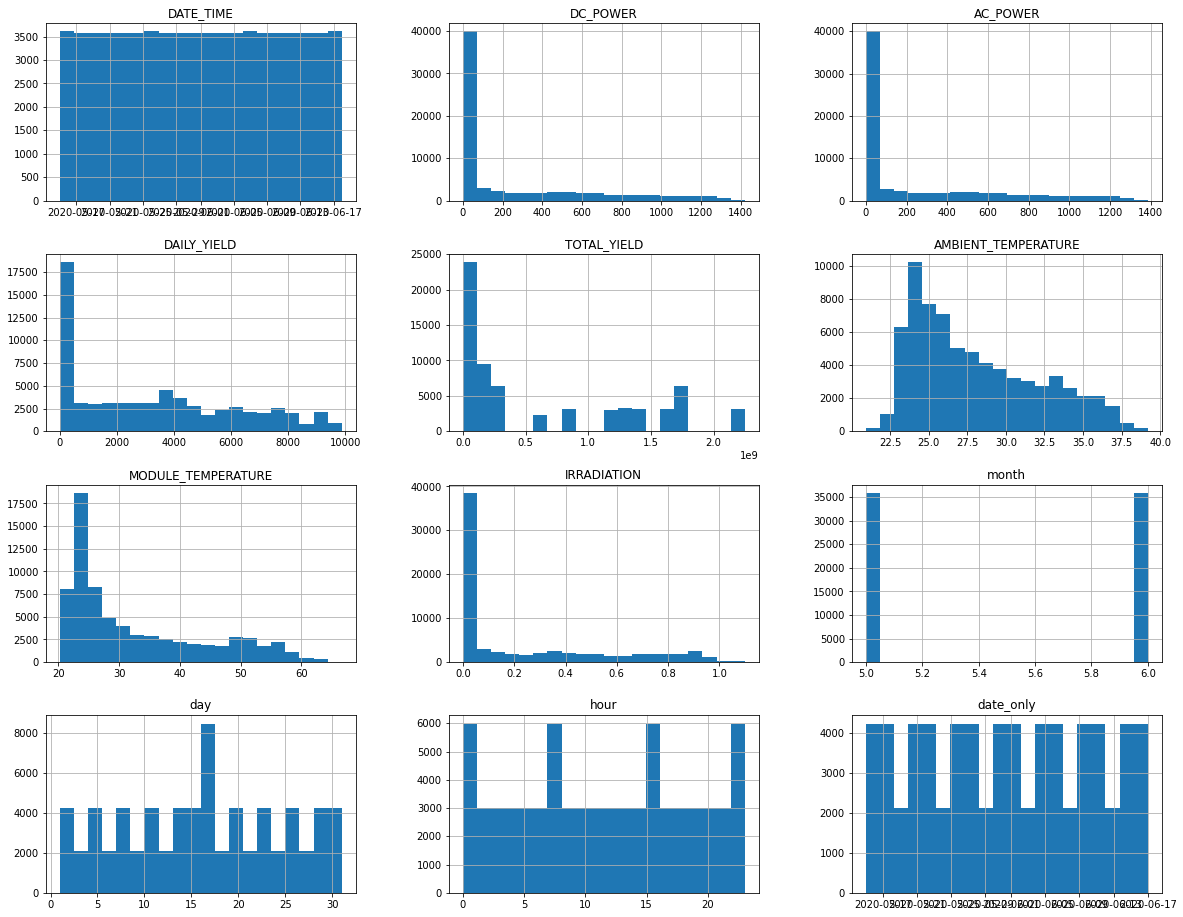

In [36]:
pd.concat(listDfPowerMerged).hist(bins = 20, figsize = (20,16))

In [37]:
dfPowerMerged = pd.concat(listDfPowerMerged)

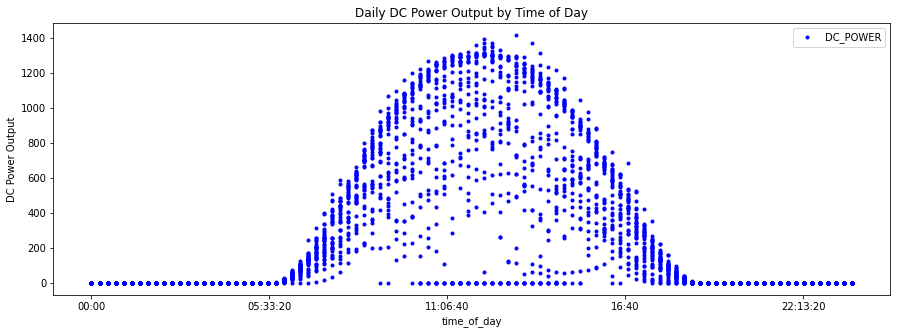

In [38]:
listDfPowerMerged[3].plot(x='time_of_day', y = 'DC_POWER' , style='b.', figsize=(15,5))
#listDfPowerMerged[0].groupby('time')['Light_conversion'].agg('mean').plot(legend=True, colormap='Reds_r')
plt.title('Daily DC Power Output by Time of Day')
plt.ylabel('DC Power Output')
plt.show()

## Plot Power Output over Time of Day for Each Inverter

In [39]:
import matplotlib.dates as mdates
xformatter = mdates.DateFormatter('%H:%M')

def subplot_by_col(df, splitCol, nrows, ncols, figsize, title, xCol, yCol, xformatter_):
  grouped = df[[xCol, yCol, splitCol]].groupby(splitCol)
  fig, axs = plt.subplots(figsize=figsize, 
                          nrows=nrows, ncols=ncols,     # fix as above
                          gridspec_kw=dict(hspace=0.4),
                          sharey=True, sharex=True) # Much control of gridspec                       
  targets = zip(grouped.groups.keys(), axs.flatten())
  today = datetime.now().date()
  for i, (key, ax) in enumerate(targets):
    x_dt = [ datetime.combine(today, t) for t in grouped.get_group(key)[xCol]]
    ax.scatter(x_dt, grouped.get_group(key)[yCol])
    ax.set_title(title + splitCol + ' {}'.format(key))
    ax.xaxis.set_major_formatter(xformatter_)
  ax.legend()
  plt.show()


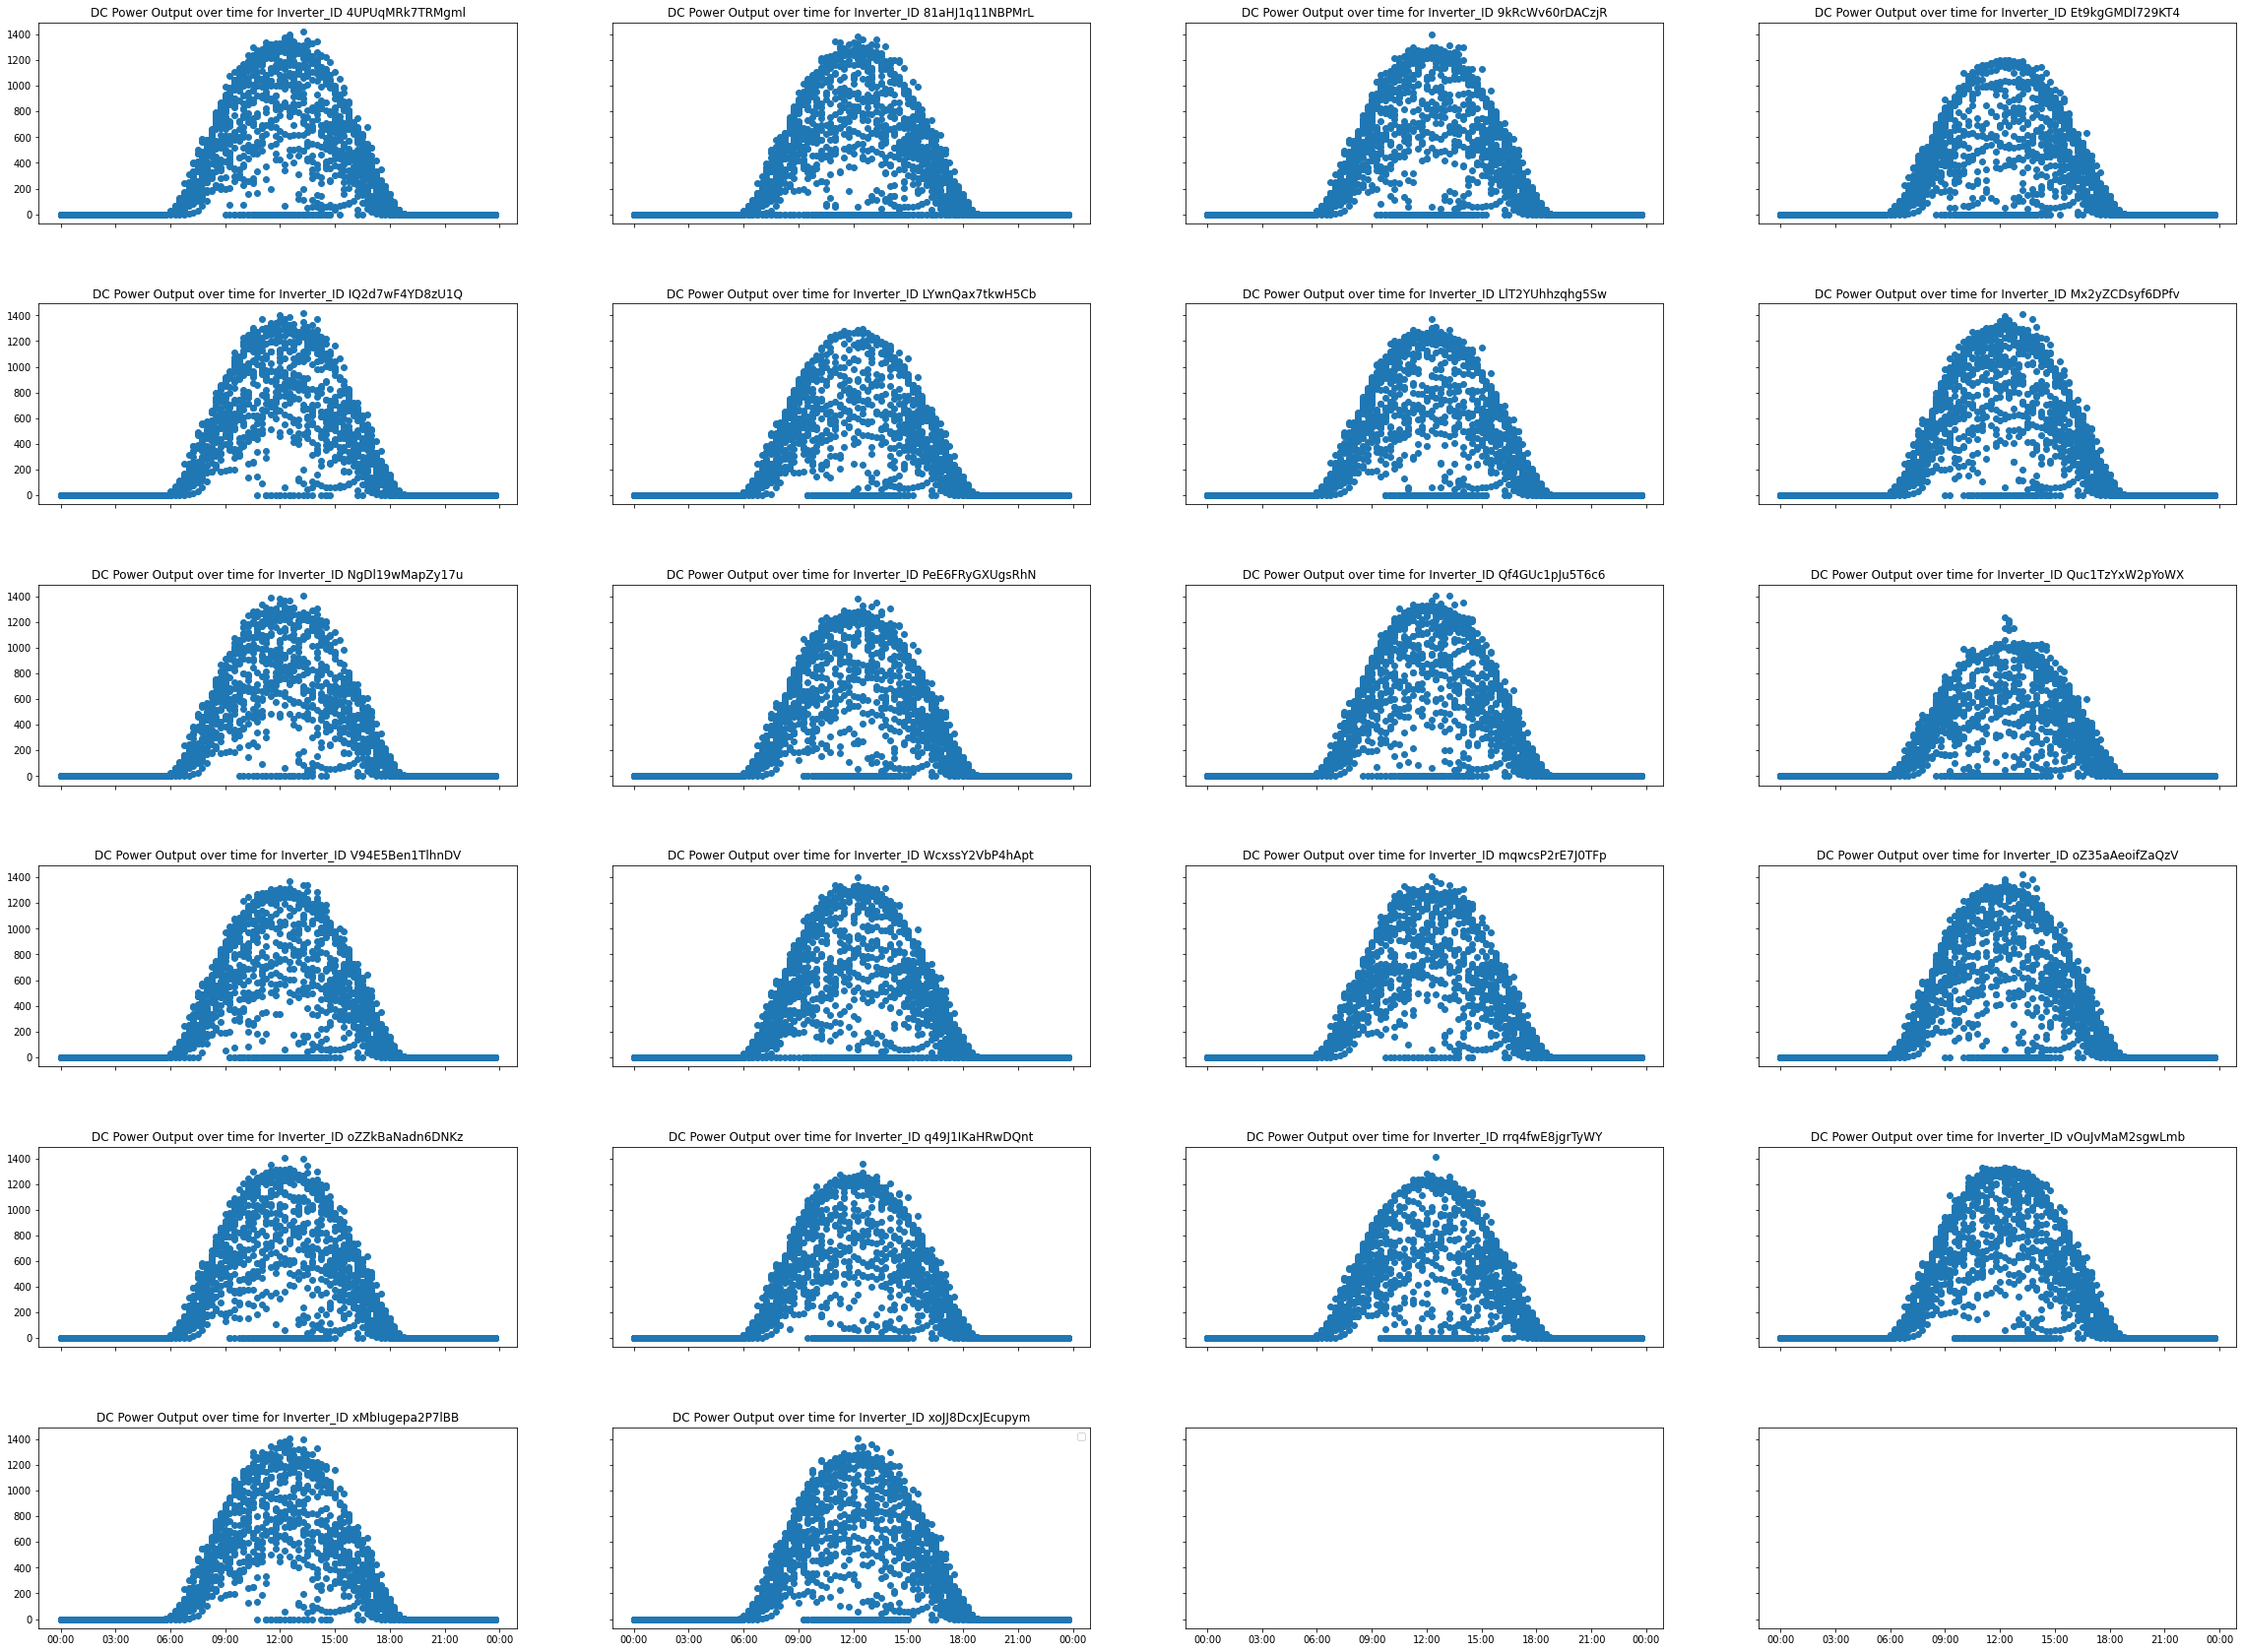

In [40]:
subplot_by_col(dfPowerMerged, 'Inverter_ID', 6, 4, (40,30), 'DC Power Output over time for ', 'time_of_day', 'DC_POWER', xformatter)

### Add Additional Variables

In [41]:
dfPowerMerged['Light_Conversion'] = dfPowerMerged['DC_POWER'] / dfPowerMerged['IRRADIATION']
dfPowerMerged['Light_Conversion'] = dfPowerMerged['Light_Conversion'].fillna(0)
dfPowerMerged['DC_Conversion'] = dfPowerMerged['AC_POWER'] / dfPowerMerged['DC_POWER']
dfPowerMerged['DC_Conversion'] = dfPowerMerged['DC_Conversion'].fillna(0)
dfPowerMerged.head()

,DATE_TIME,Inverter_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,month,day,hour,time_of_day,date_only,Light_Conversion,DC_Conversion
0,2020-05-15 00:00:00,V94E5Ben1TlhnDV,0.0,0.0,0.0,1.412083e+09,27.004764,25.060789,0.0,5,15,0,00:00:00,2020-05-15,0.0,0.0
1,2020-05-15 00:15:00,V94E5Ben1TlhnDV,0.0,0.0,0.0,1.412083e+09,26.880811,24.421869,0.0,5,15,0,00:15:00,2020-05-15,0.0,0.0
2,2020-05-15 00:30:00,V94E5Ben1TlhnDV,0.0,0.0,0.0,1.412083e+09,26.682055,24.427290,0.0,5,15,0,00:30:00,2020-05-15,0.0,0.0
3,2020-05-15 00:45:00,V94E5Ben1TlhnDV,0.0,0.0,0.0,1.412083e+09,26.500589,24.420678,0.0,5,15,0,00:45:00,2020-05-15,0.0,0.0
4,2020-05-15 01:00:00,V94E5Ben1TlhnDV,0.0,0.0,0.0,1.412083e+09,26.596148,25.088210,0.0,5,15,1,01:00:00,2020-05-15,0.0,0.0


### Investigate Irradiation to DC Power conversion efficiency

#### Light Conversion Rate Over Time of Day
From the below graph we could observe that:


1.   For all inverters, light conversion rate generally remain stable within a range of variations over the course of a day
2.  Almost all inverters experience shutdowns (DC Power drop to 0) during peak irradiation hours, some inverters shotdown less than the others



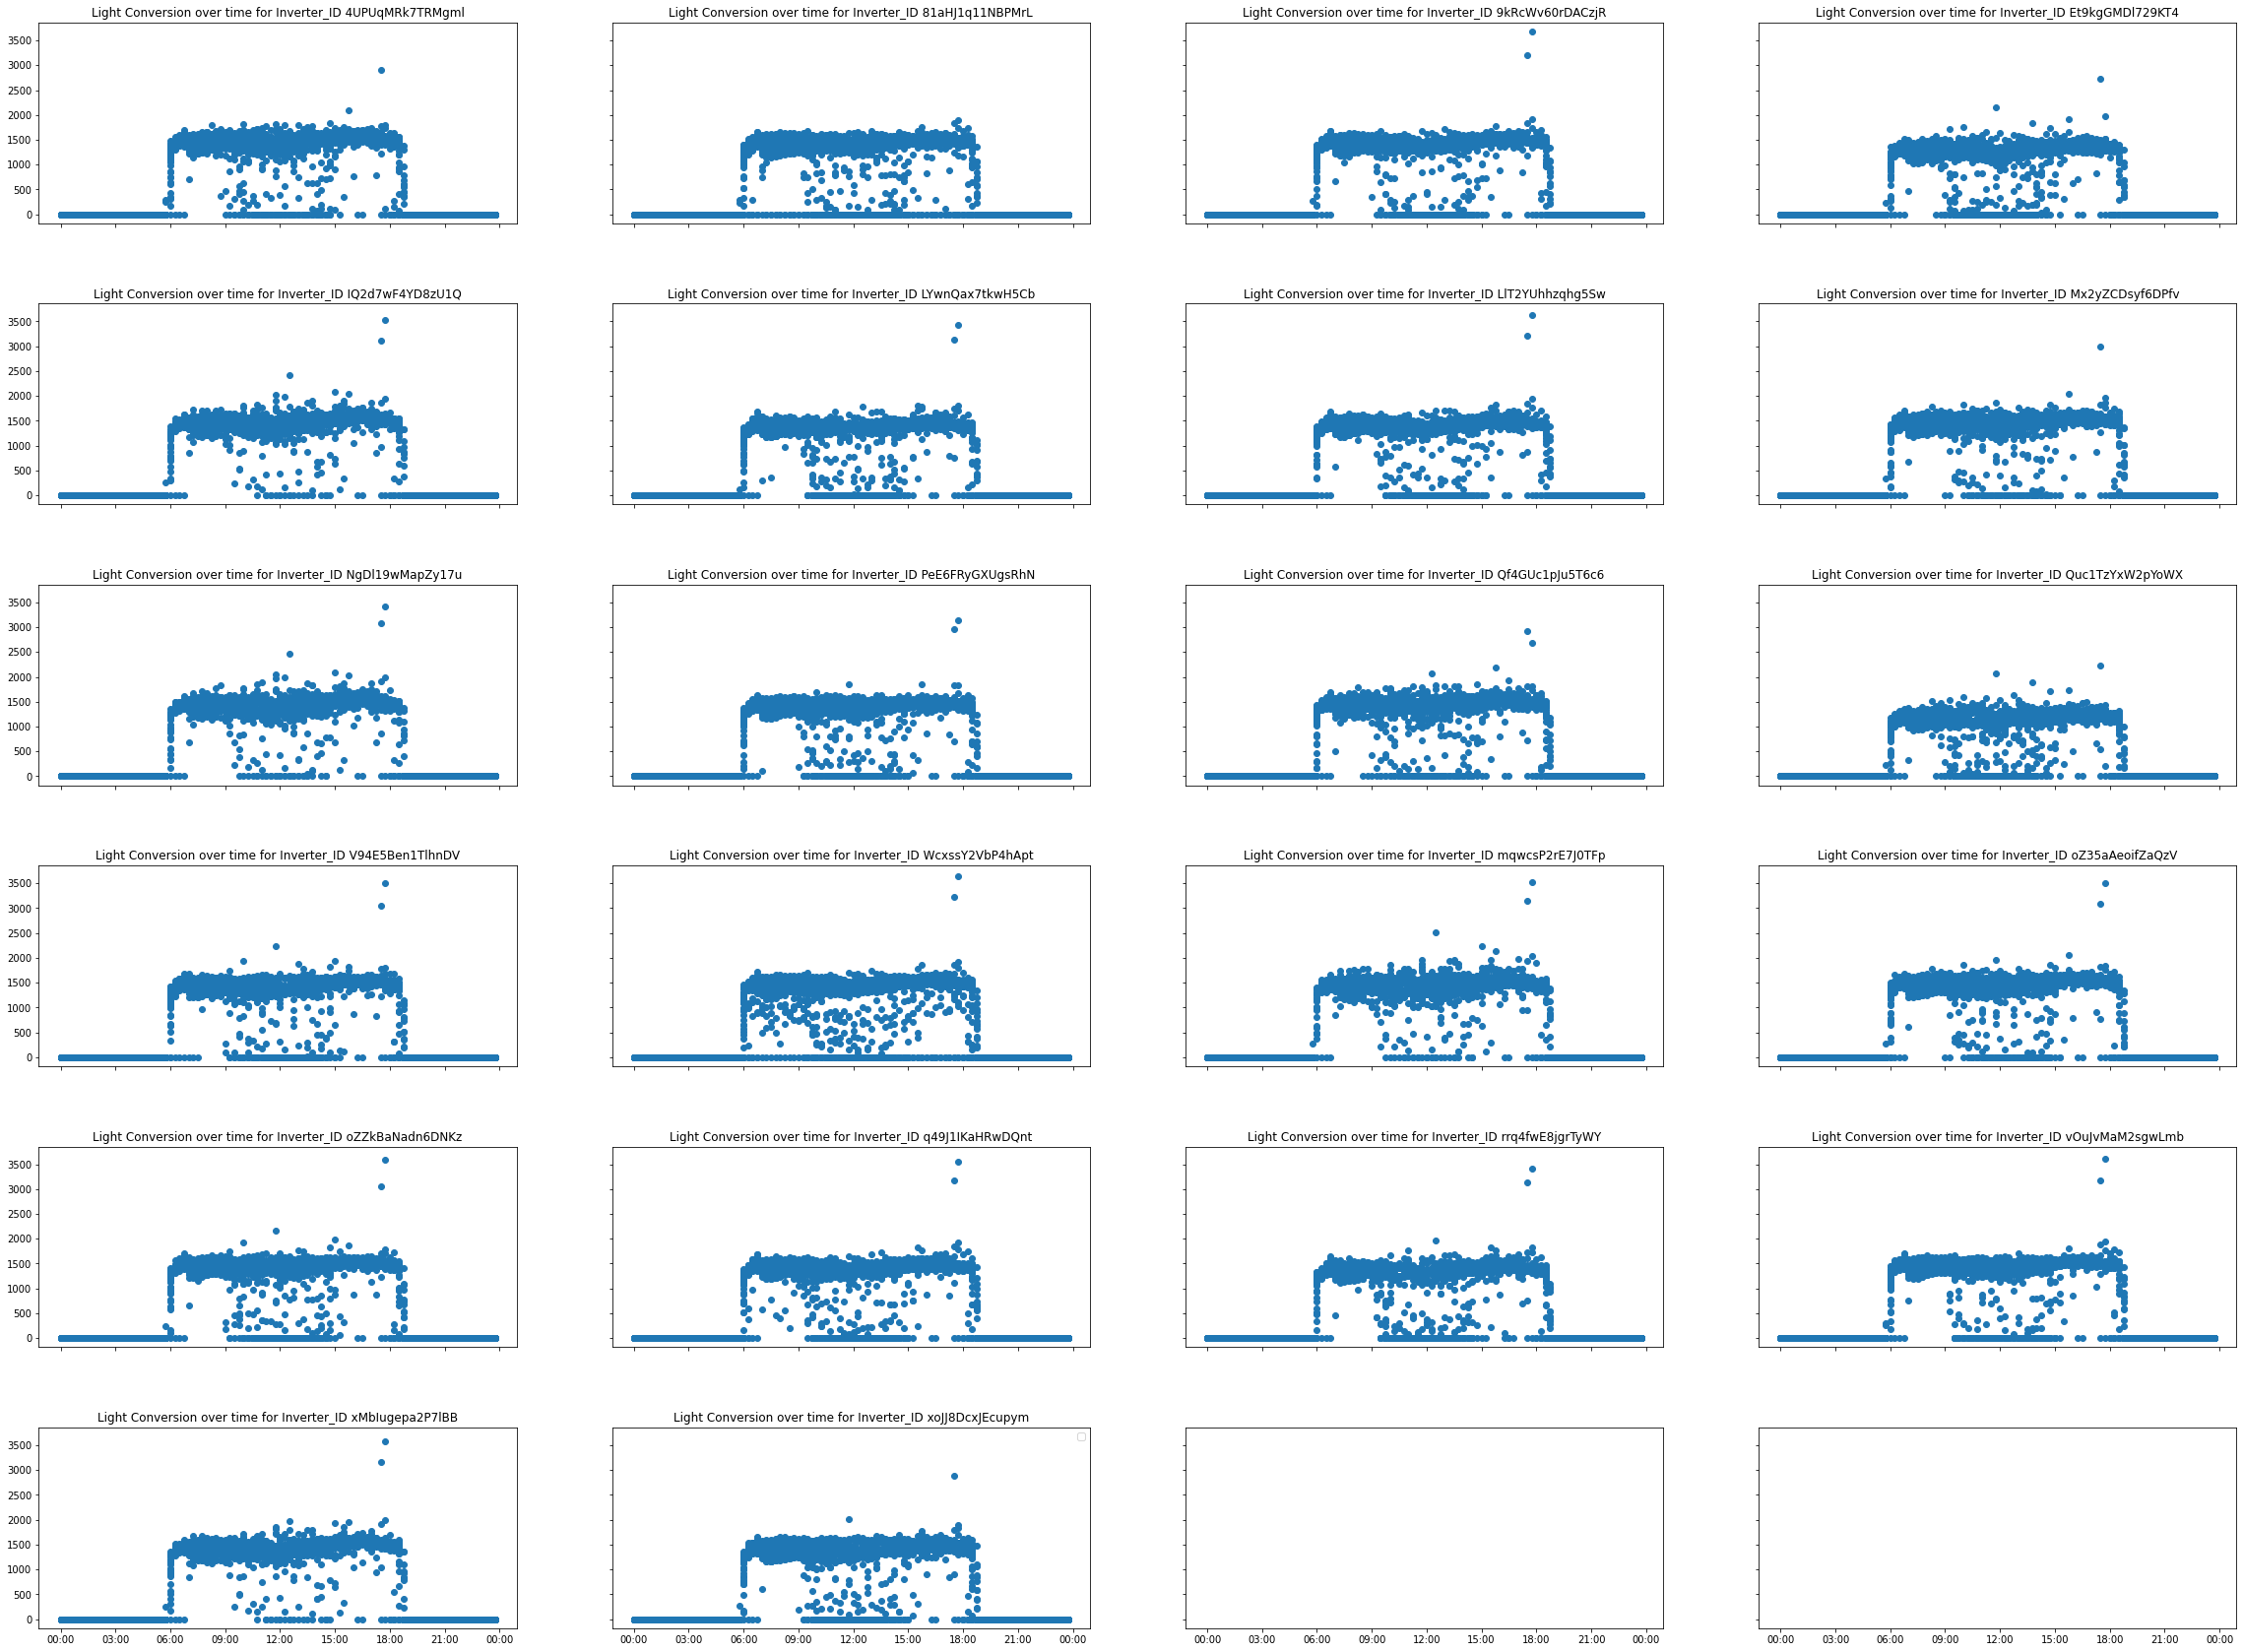

In [42]:
subplot_by_col(dfPowerMerged, 'Inverter_ID', 6, 4, (40,30), 'Light Conversion over time for ', 'time_of_day', 'Light_Conversion', xformatter)

In [43]:
dfPowerMerged['mean_Light_Conversion'] = dfPowerMerged.groupby(by=['Inverter_ID','time_of_day'])['Light_Conversion'].transform('mean')

#### Mean Light Conversion Rate Over Time of Day
Average the light conversion rate for each inverter across 34 days. From the below graph we could observe:


1.   From 6-9AM and 15-18PM the light conversion rate remains stable and high
2.   During 9AM-15PM the light conversion rate decreases to nearly all day low then climbs back
3.   The dip in converion rate during 9AM-15PM could be due to the more often shotdowns during this period 

To fruther investigate the light conversion rate, we should ignore time periods when electricity output is 0 when irradiation is not (shutdowns).



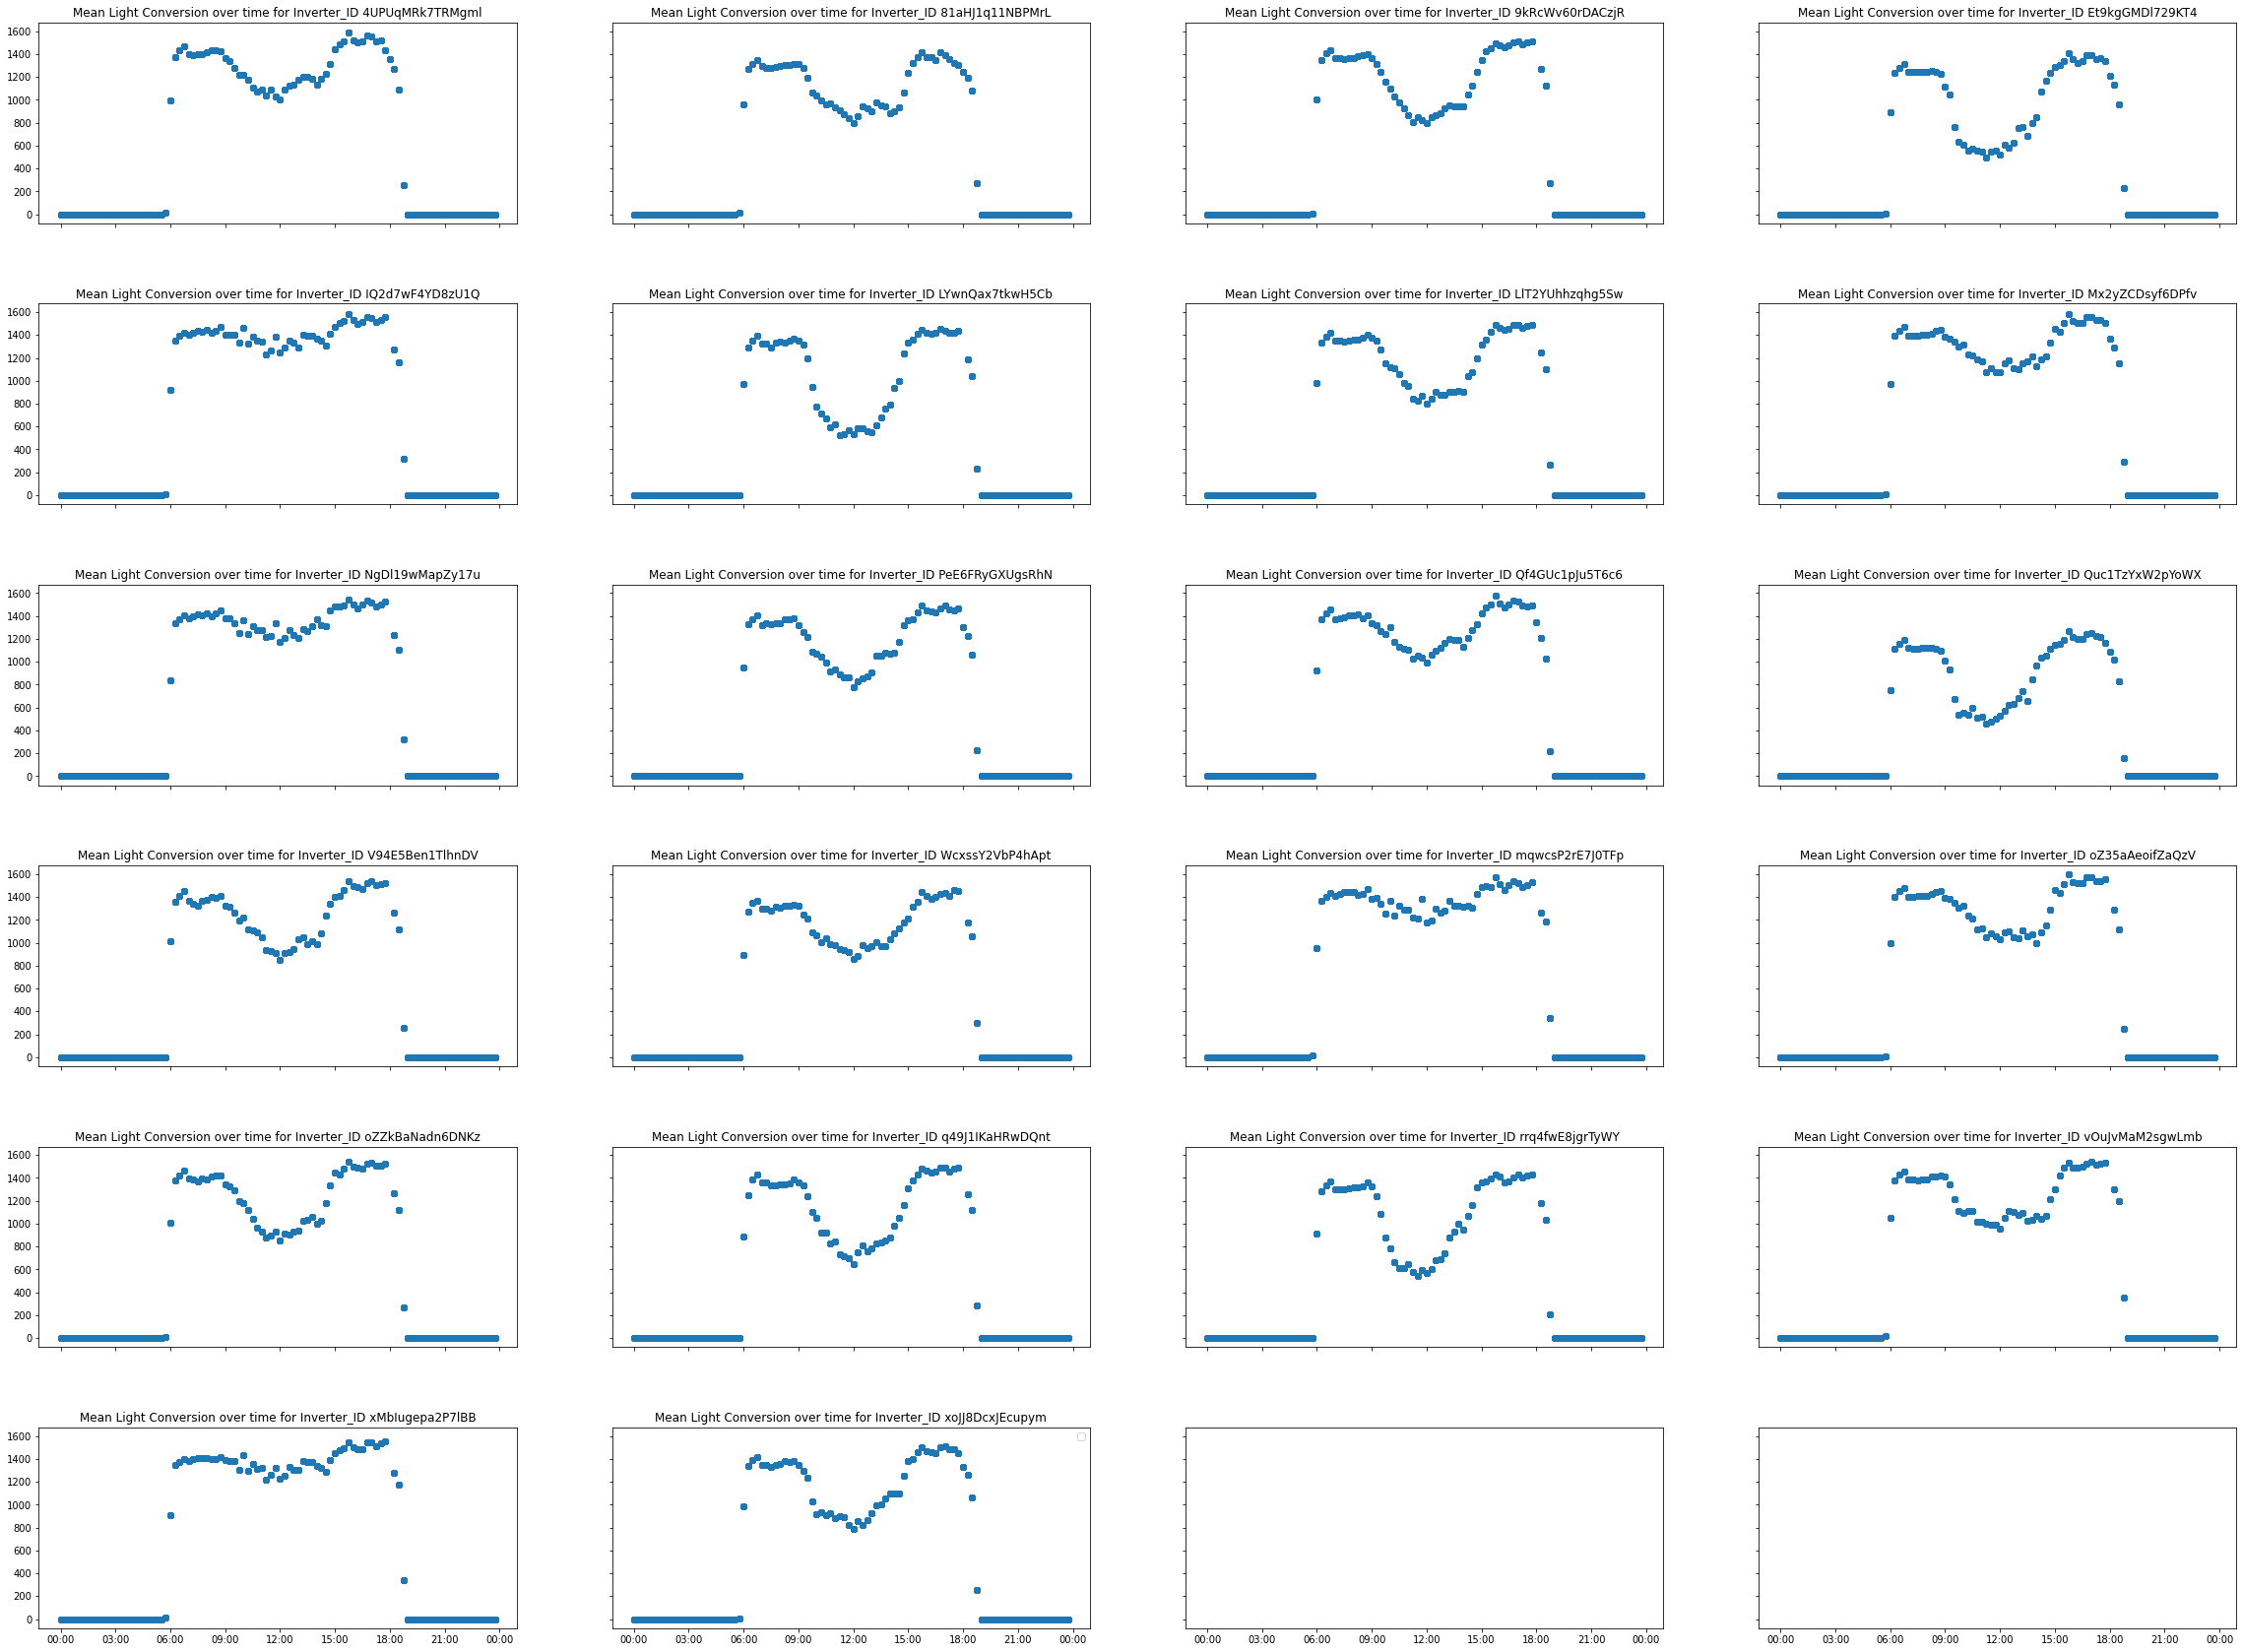

In [44]:
subplot_by_col(dfPowerMerged, 'Inverter_ID', 6, 4, (40,30), 'Mean Light Conversion over time for ', 'time_of_day', 'mean_Light_Conversion', xformatter)

From the above observation, we add another feature called is_peak_hour. For time period between 9AM-15PM we defined the value as True, otherwise False.

In [45]:
dfPowerMerged['is_peak_hour'] = (dfPowerMerged['hour'] >= 9) & (dfPowerMerged['hour'] <=15)

After removing all time period when irradiation is not 0 but power output is (shotdowns) and plot the mean light conversion over time again, we could observe:


1.   Mean light conversion over time of day still reduce during 9AM-15PM for most of inverters after discounting shutdowns
2.   This could be due to the irradiation during peak sun hours exceeds the power generation capacity for the solar panels. Becuase we see though the power generation is not as efficient during the peak hours but the power generation per unit time is still higher during the peak hours



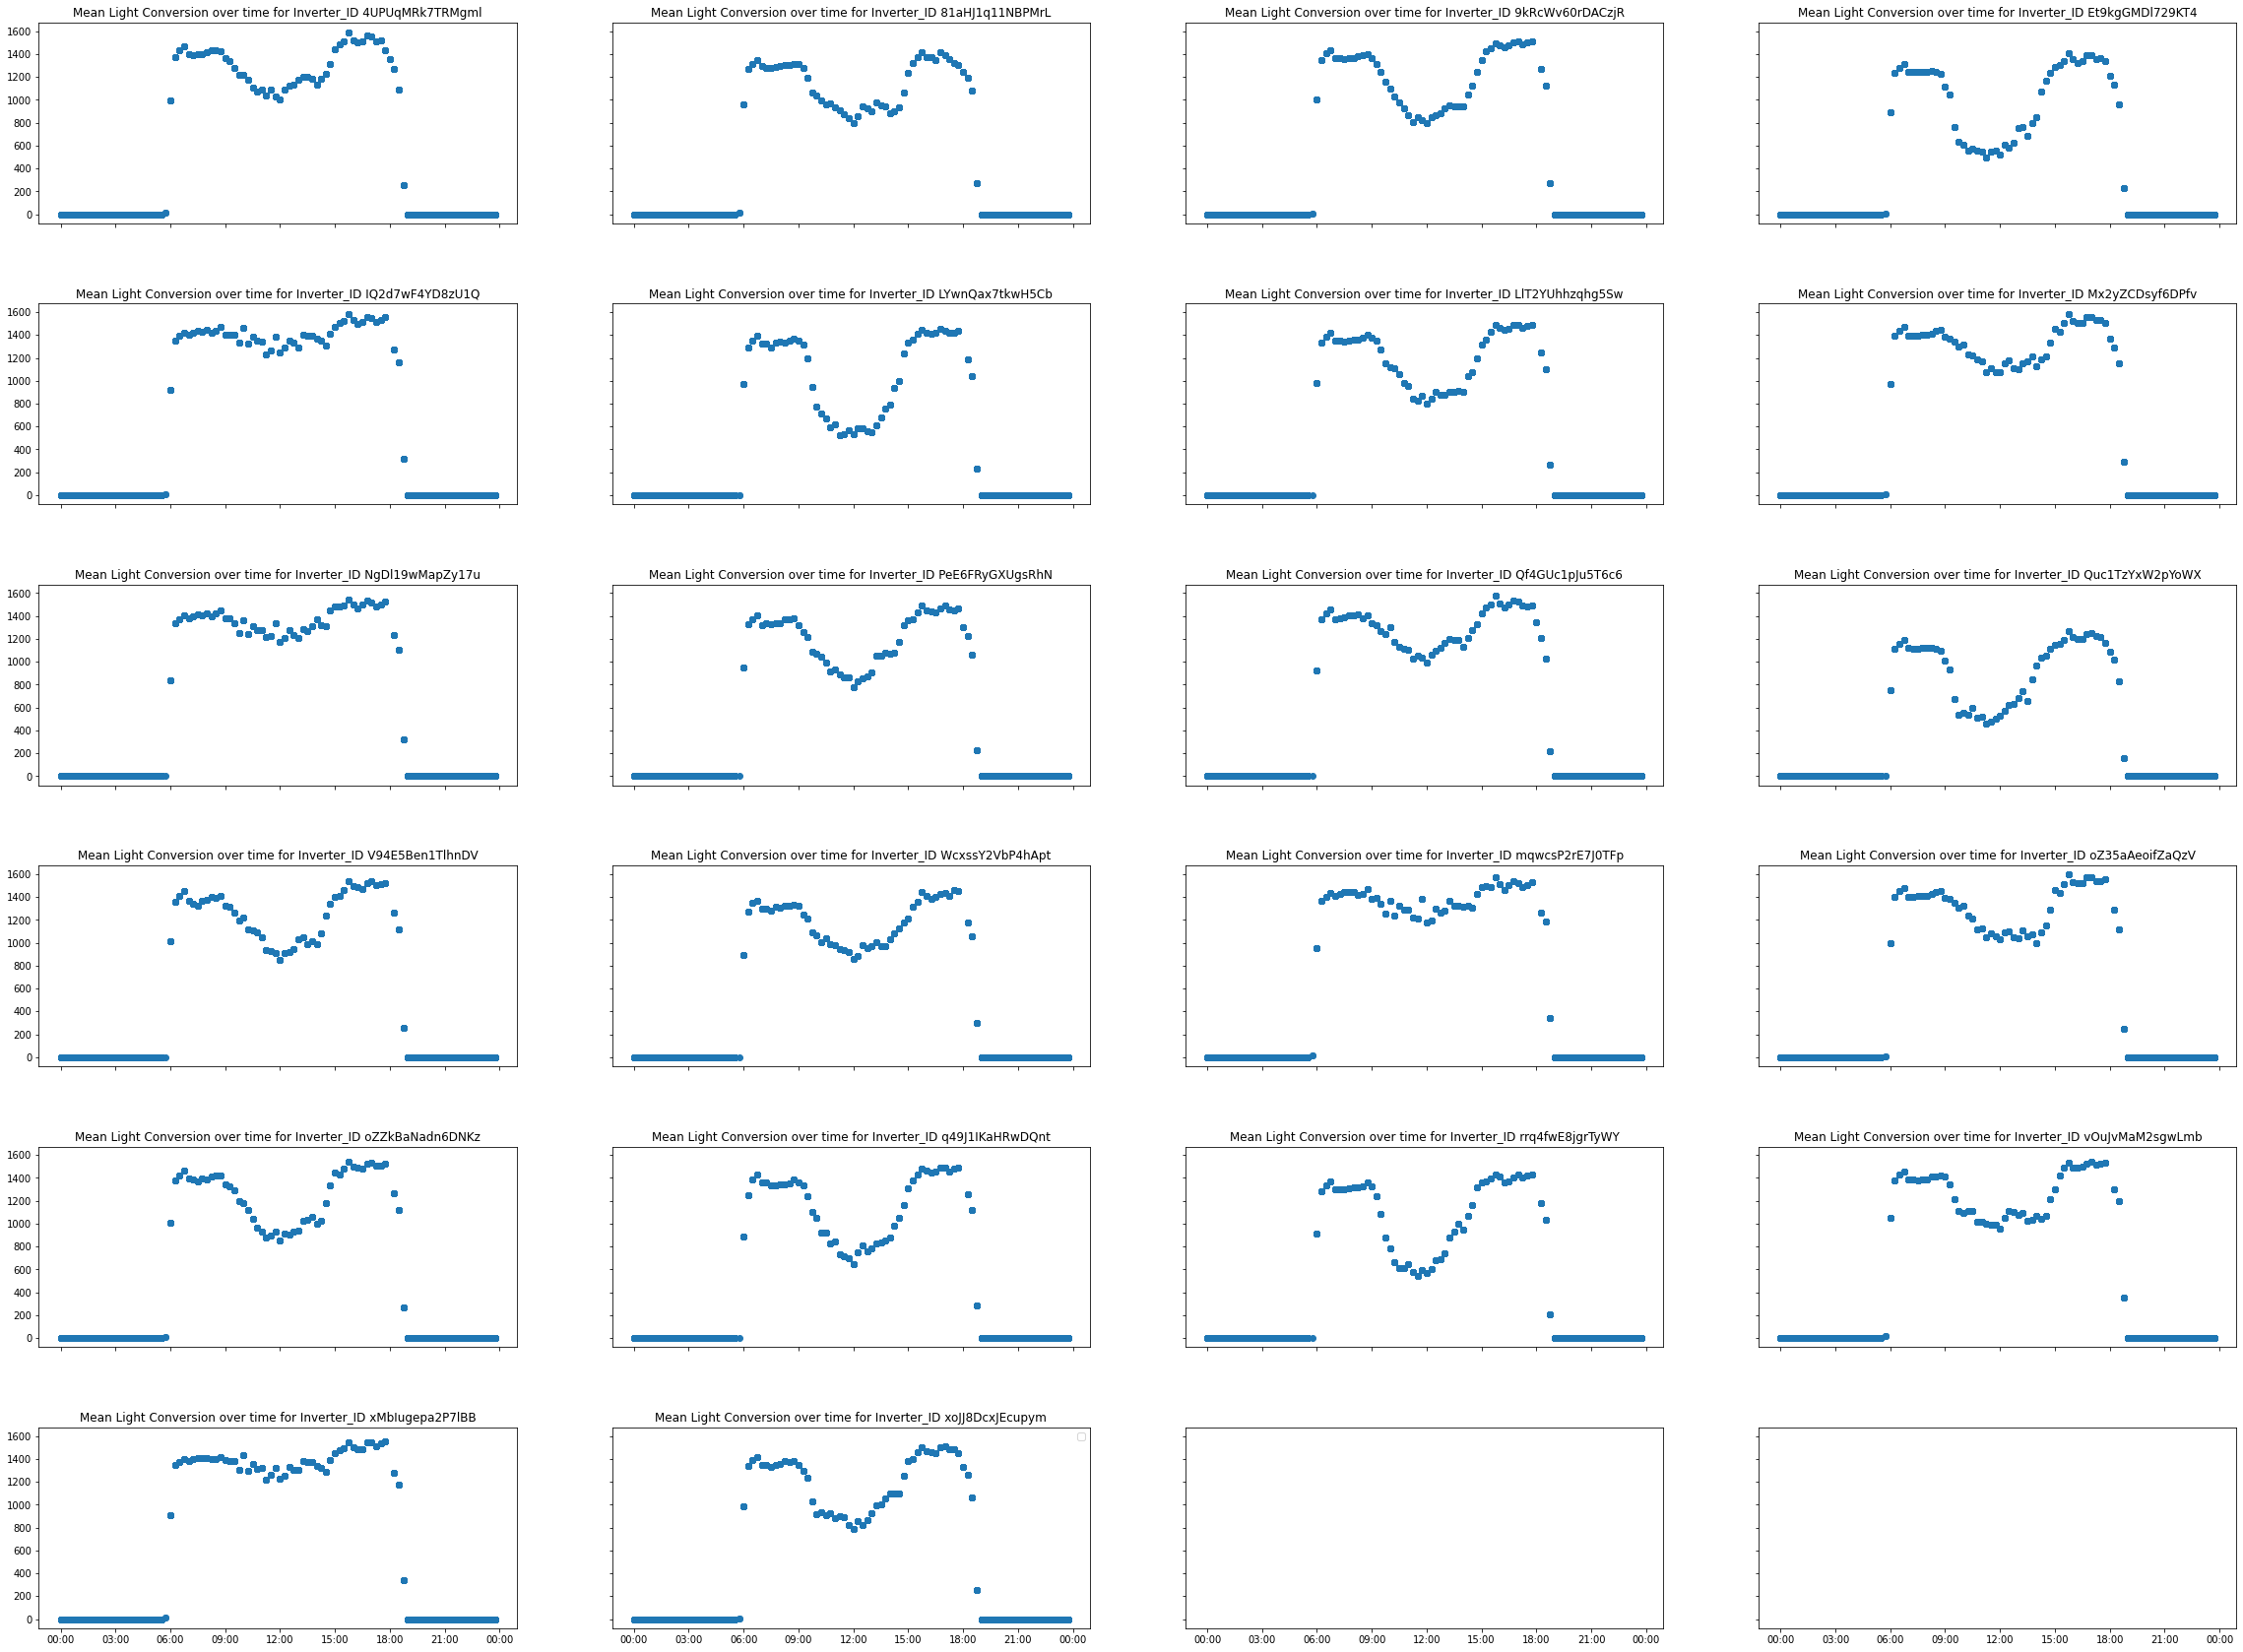

In [46]:
dfPowerMergedRemoveShotDown = dfPowerMerged[(dfPowerMerged['DC_POWER']>0) | (dfPowerMerged['IRRADIATION']==0)]
subplot_by_col(dfPowerMergedRemoveShotDown, 
               'Inverter_ID', 6, 4, (40,30), 'Mean Light Conversion over time for ', 'time_of_day', 'mean_Light_Conversion', xformatter)

#### Mean Light Conversion Rate between Peak and Non-peak Irradiation Hours 
The below graph breaks down time periods by peak and non-peak irradiation hours and showcases how different are the mean light conversion rate distributes between these 2 parts of the day (we consider only time periods when there are sunshine and power output). From it we could observe:


1.   For most inverters, the mean light conversion rate during non-peak hours is higher and more consistent (both variances within one inverter and across inverters are relatively small) comapred to peak hours
2.   There are significant differences between performance of some inverters than others
3.   The inefficient inverters could be considered require cleaning and maintenance


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]), <a list of 22 Text major ticklabel objects>)

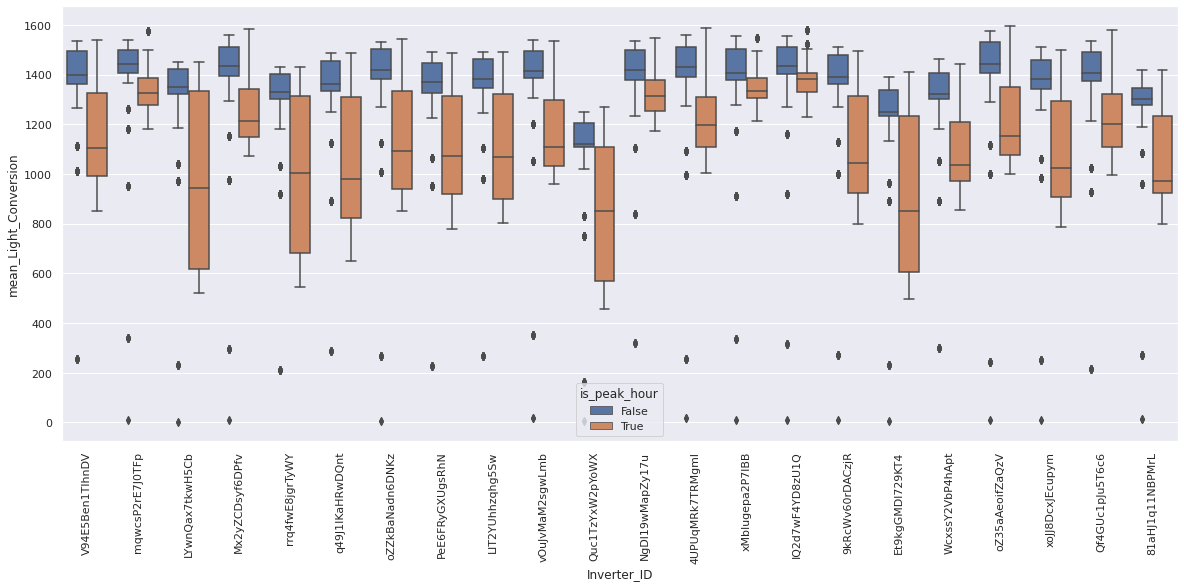

In [47]:
import seaborn as sns

sns.set(rc={'figure.figsize':(20,8)})
sns.boxplot(data=dfPowerMergedRemoveShotDown[dfPowerMergedRemoveShotDown['mean_Light_Conversion']>0], 
            x ='Inverter_ID', y='mean_Light_Conversion', hue='is_peak_hour')
plt.xticks(rotation=90)

### Panels Require Maintenance and Cleaning
From the above graph we could see the below inverters maybe connected with inefficent panels that may require maintenance and cleaning. They are inverter:


1.   Et9kgGMDl729KT4
2.   Quc1TzYxW2pYoWX

On the contrary, there are also converters connected with panels that are highly efficient and consistent. They are inverter:


1.   IQ2d7wF4YD8zU1Q
2.   xMbIugepa2P7lBB





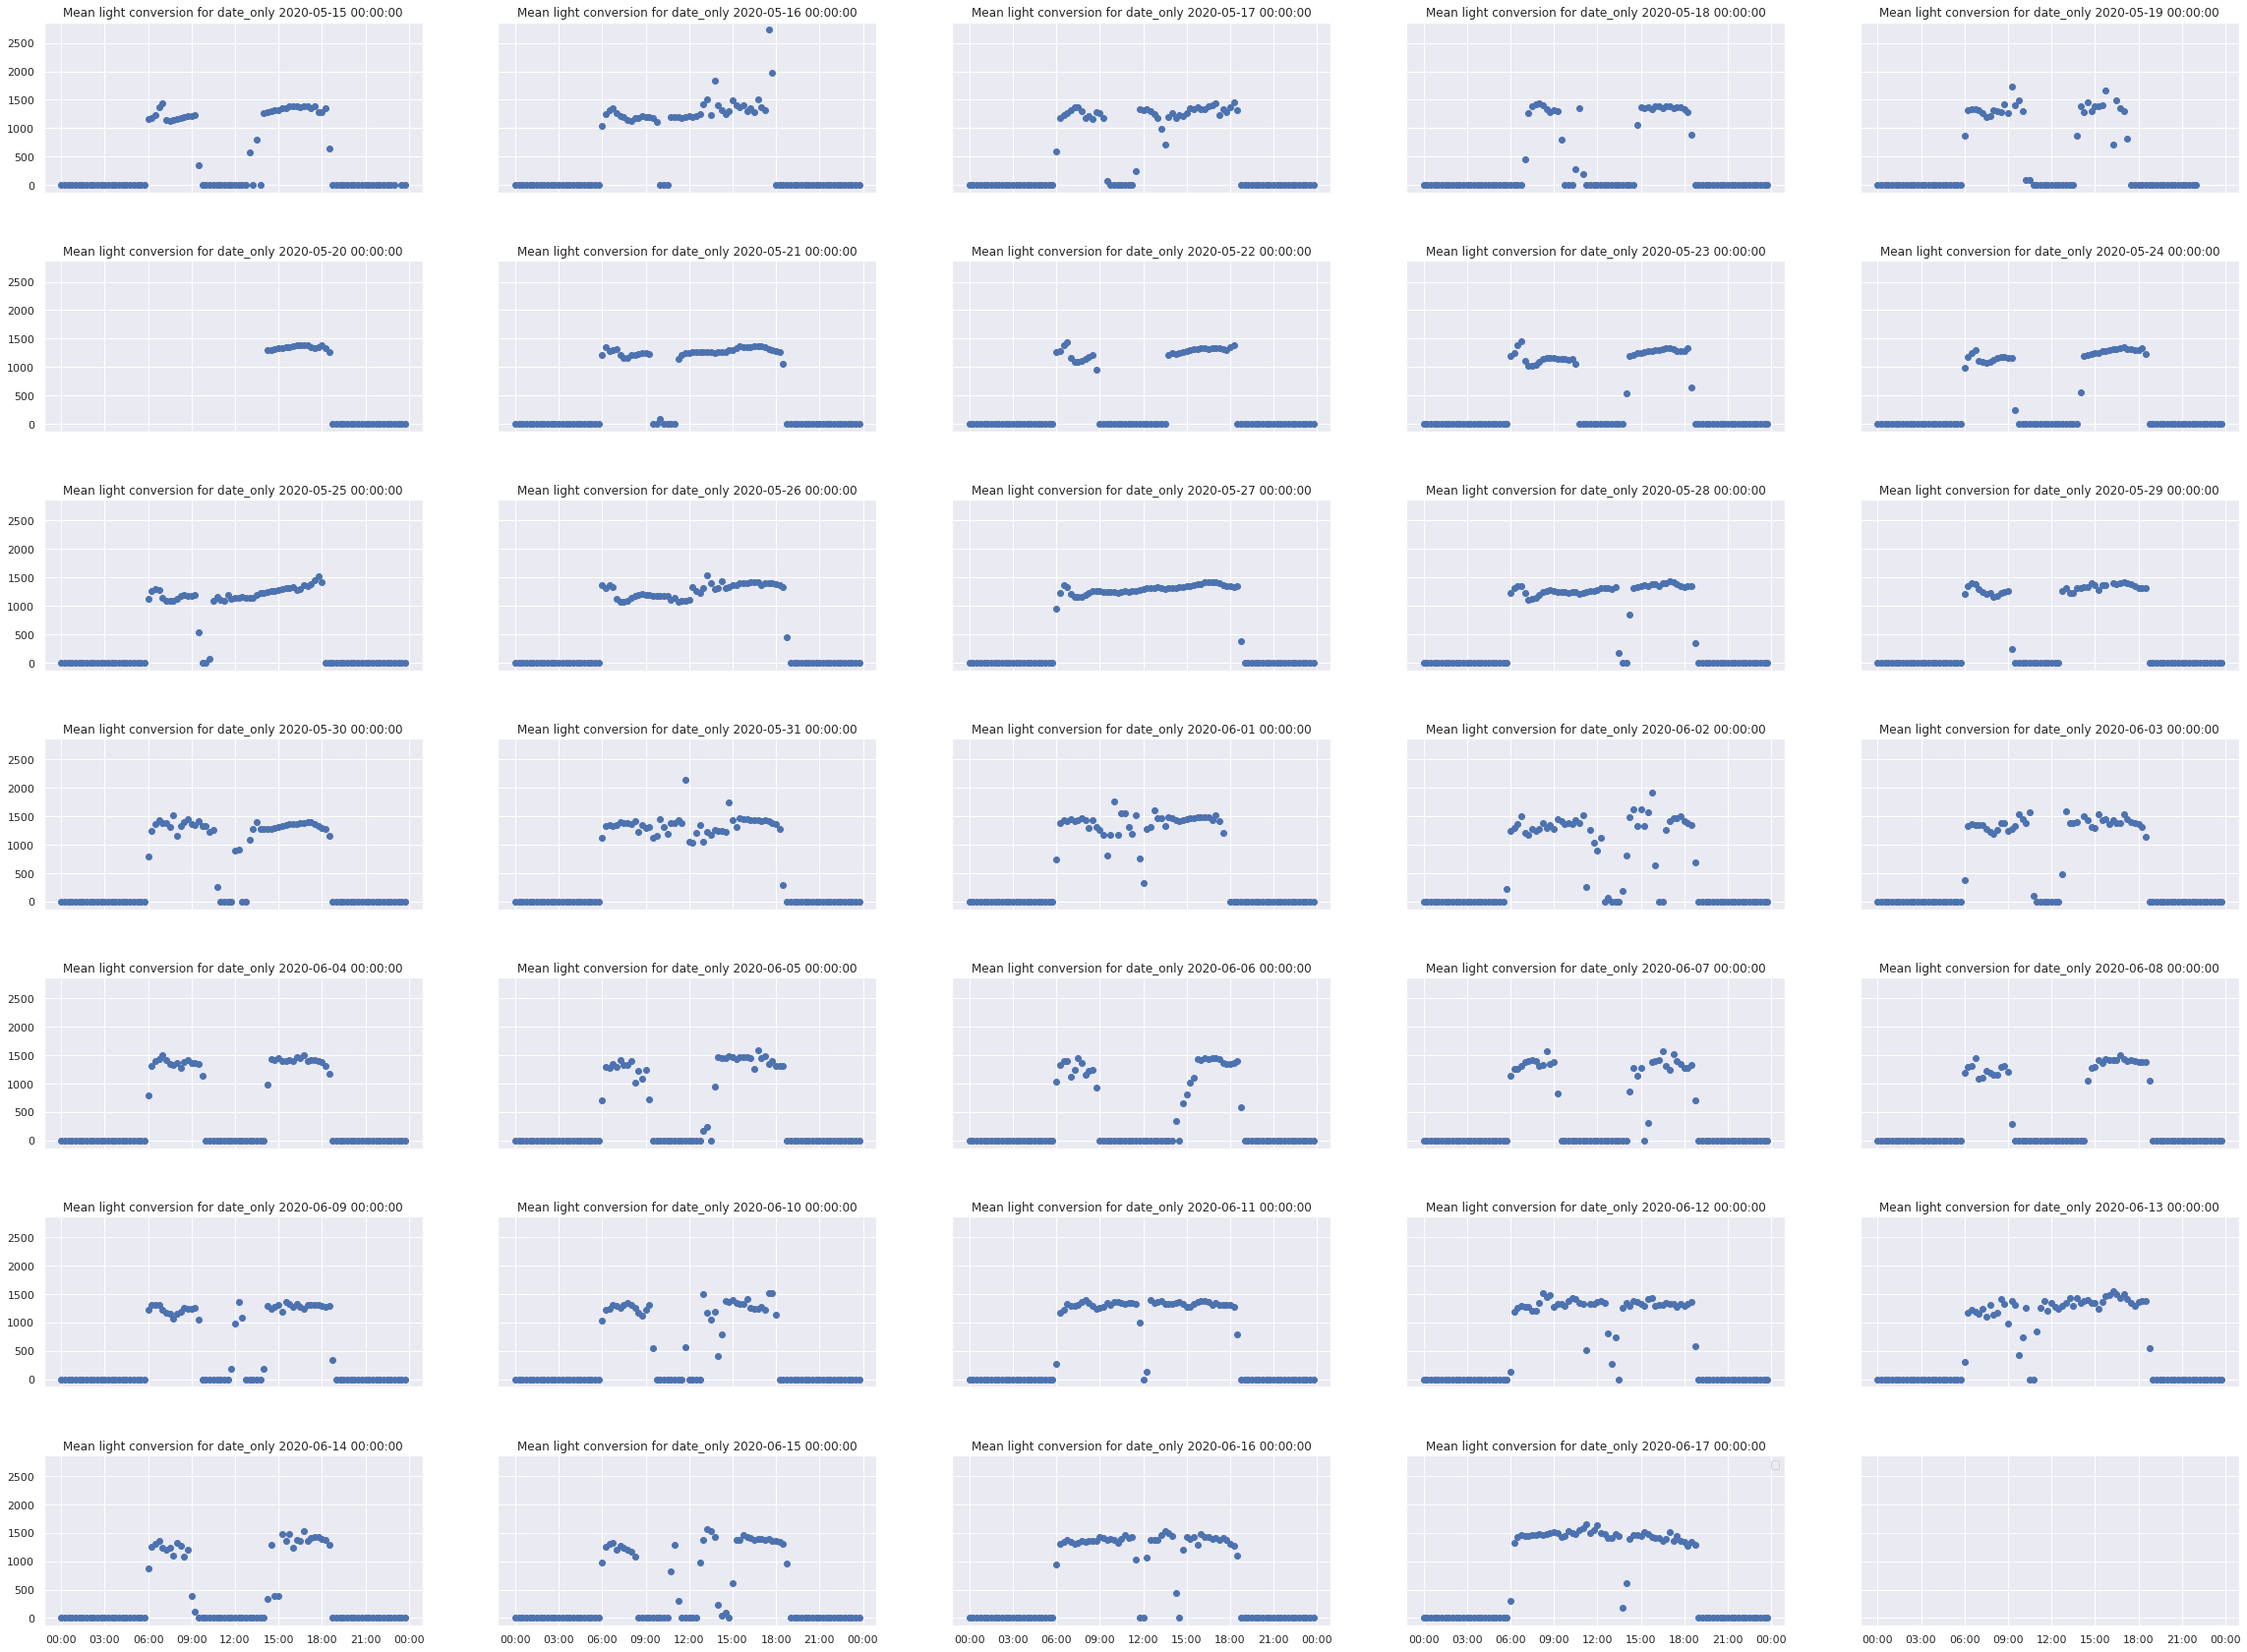

In [48]:
dfPowerMerged_9KT4 = dfPowerMerged[dfPowerMerged['Inverter_ID']=='Et9kgGMDl729KT4']
subplot_by_col(dfPowerMerged_9KT4, 
               'date_only', 7, 5, (40,30), 'Mean light conversion for ', 'time_of_day', 'Light_Conversion', xformatter)

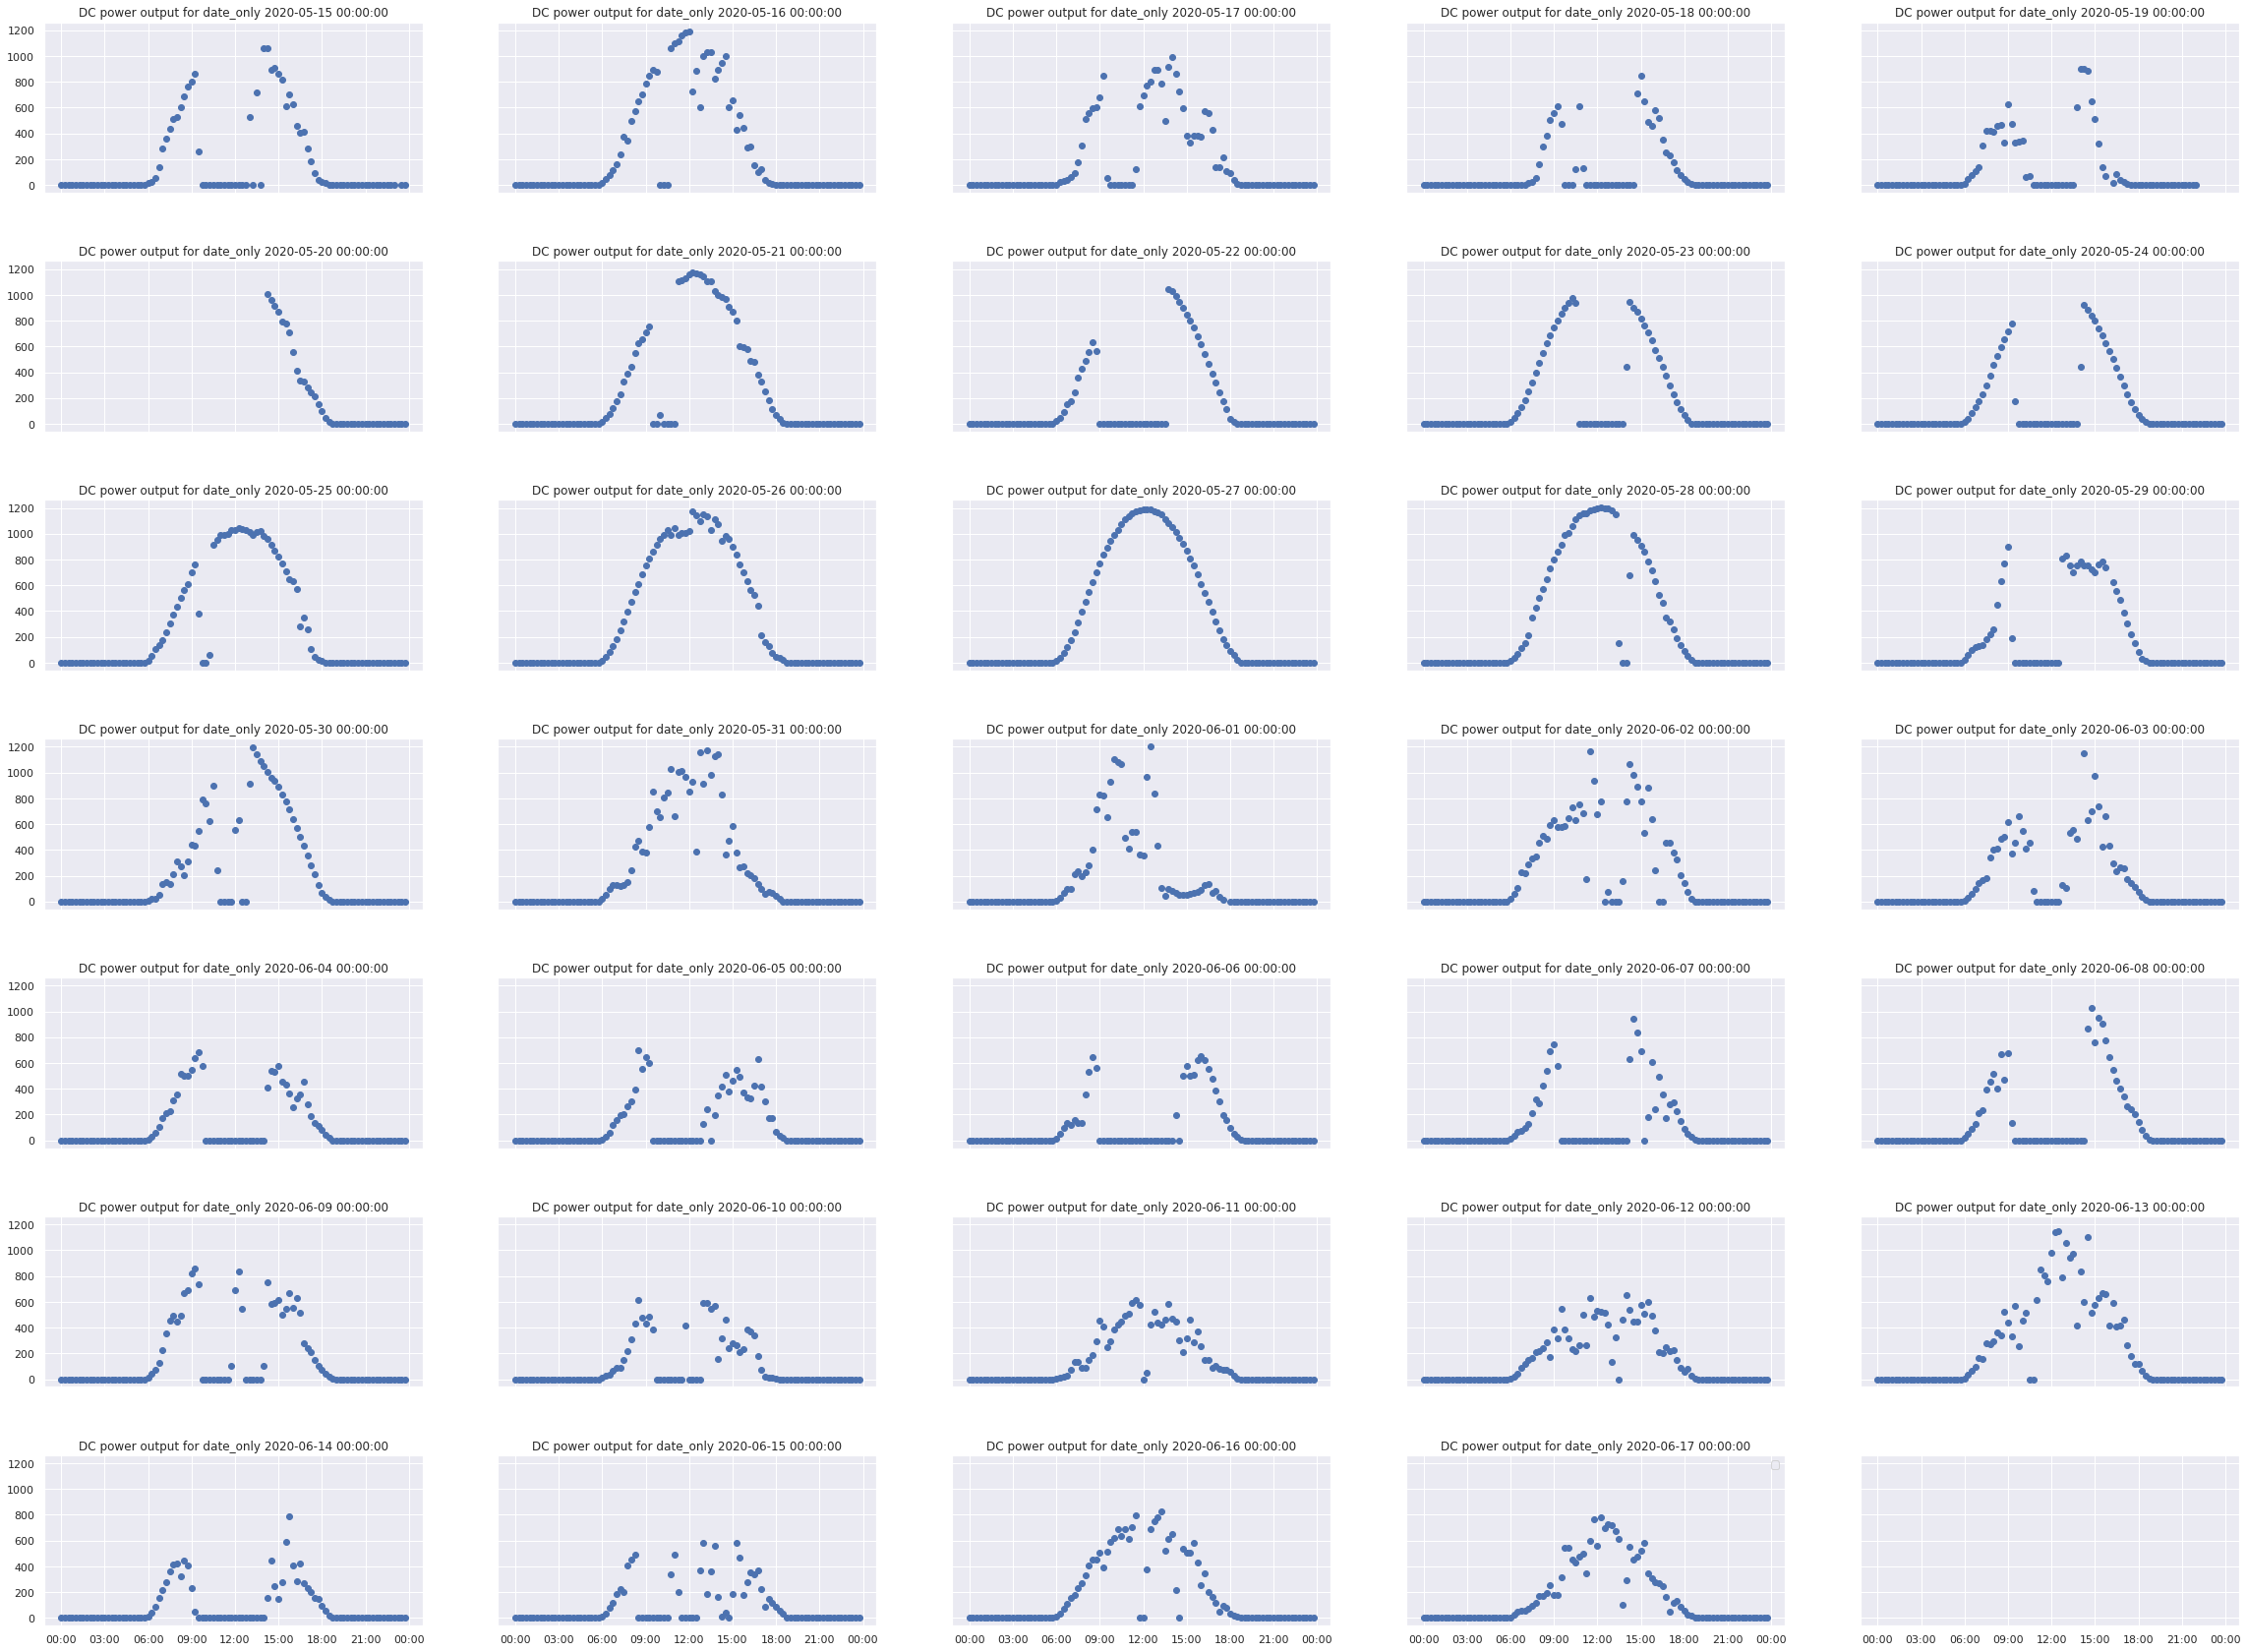

In [49]:
subplot_by_col(dfPowerMerged_9KT4, 
               'date_only', 7, 5, (40,30), 'DC power output for ', 'time_of_day', 'DC_POWER', xformatter)

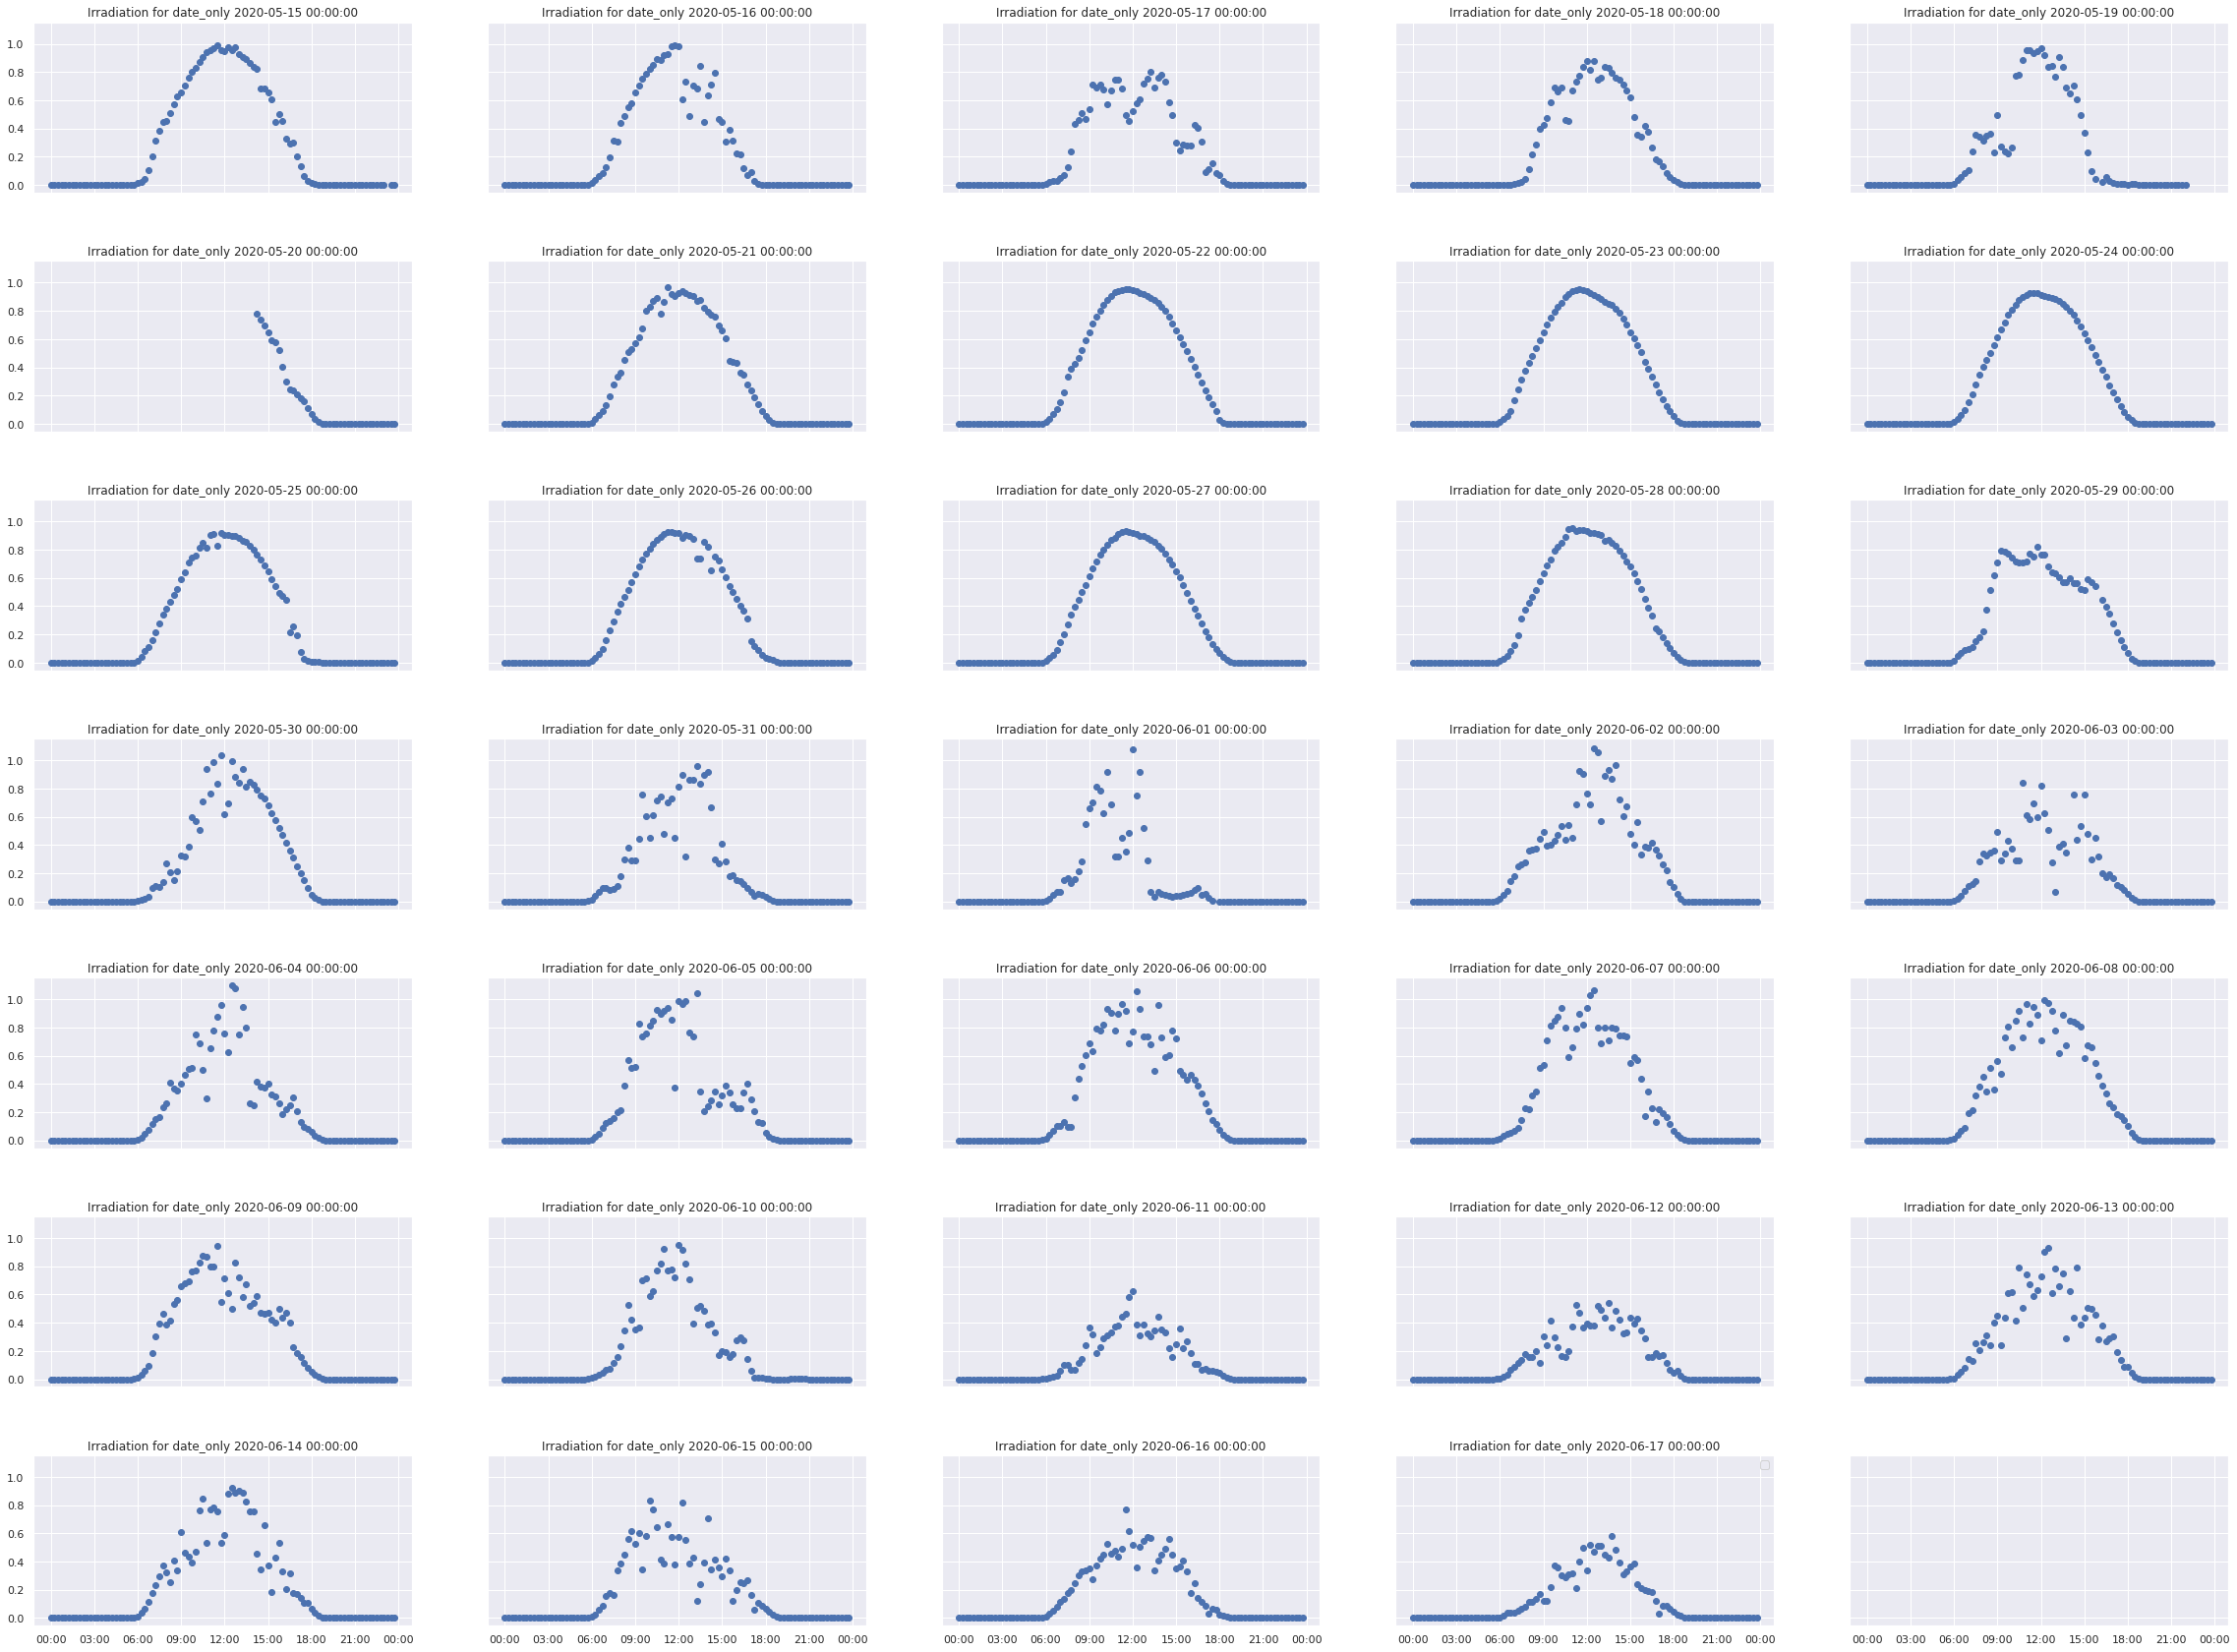

In [50]:
dfPowerMerged_9KT4 = dfPowerMerged[dfPowerMerged['Inverter_ID']=='Et9kgGMDl729KT4']
subplot_by_col(dfPowerMerged_9KT4, 
               'date_only', 7, 5, (40,30), 'Irradiation for ', 'time_of_day', 'IRRADIATION', xformatter)

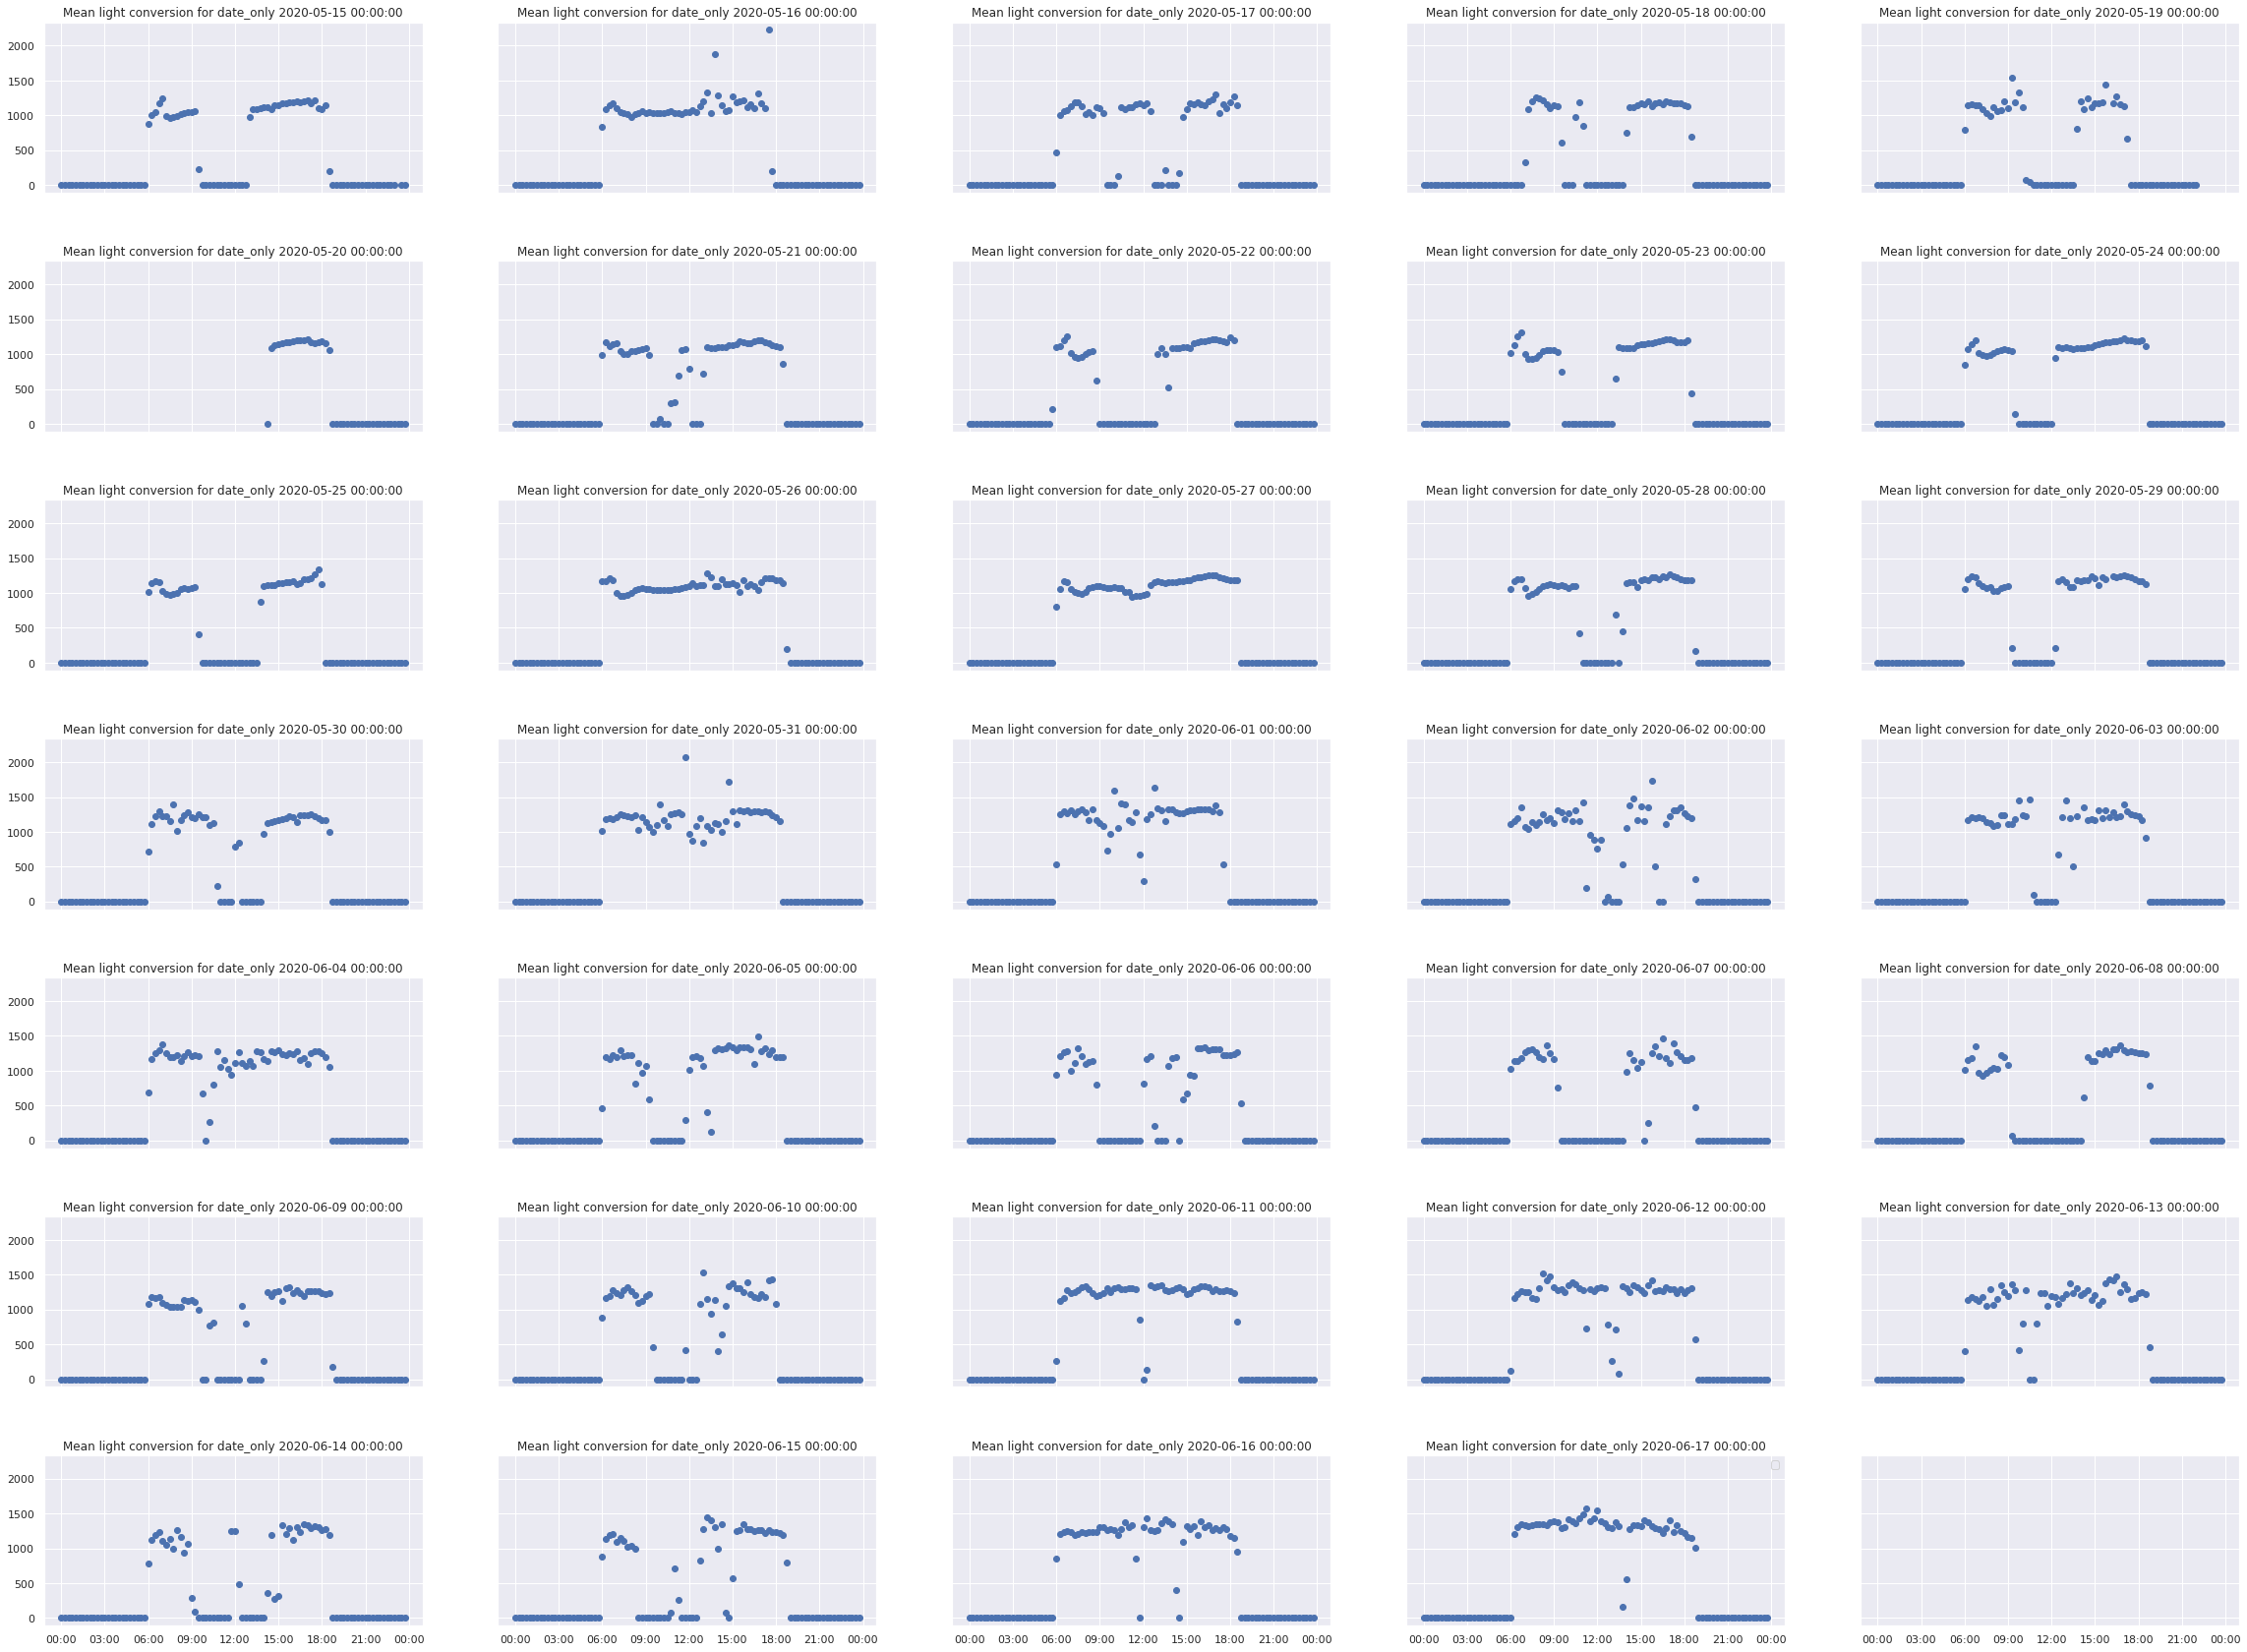

In [51]:
dfPowerMerged_YoWX = dfPowerMerged[dfPowerMerged['Inverter_ID']=='Quc1TzYxW2pYoWX']
subplot_by_col(dfPowerMerged_YoWX, 
               'date_only', 7, 5, (40,30), 'Mean light conversion for ', 'time_of_day', 'Light_Conversion', xformatter)

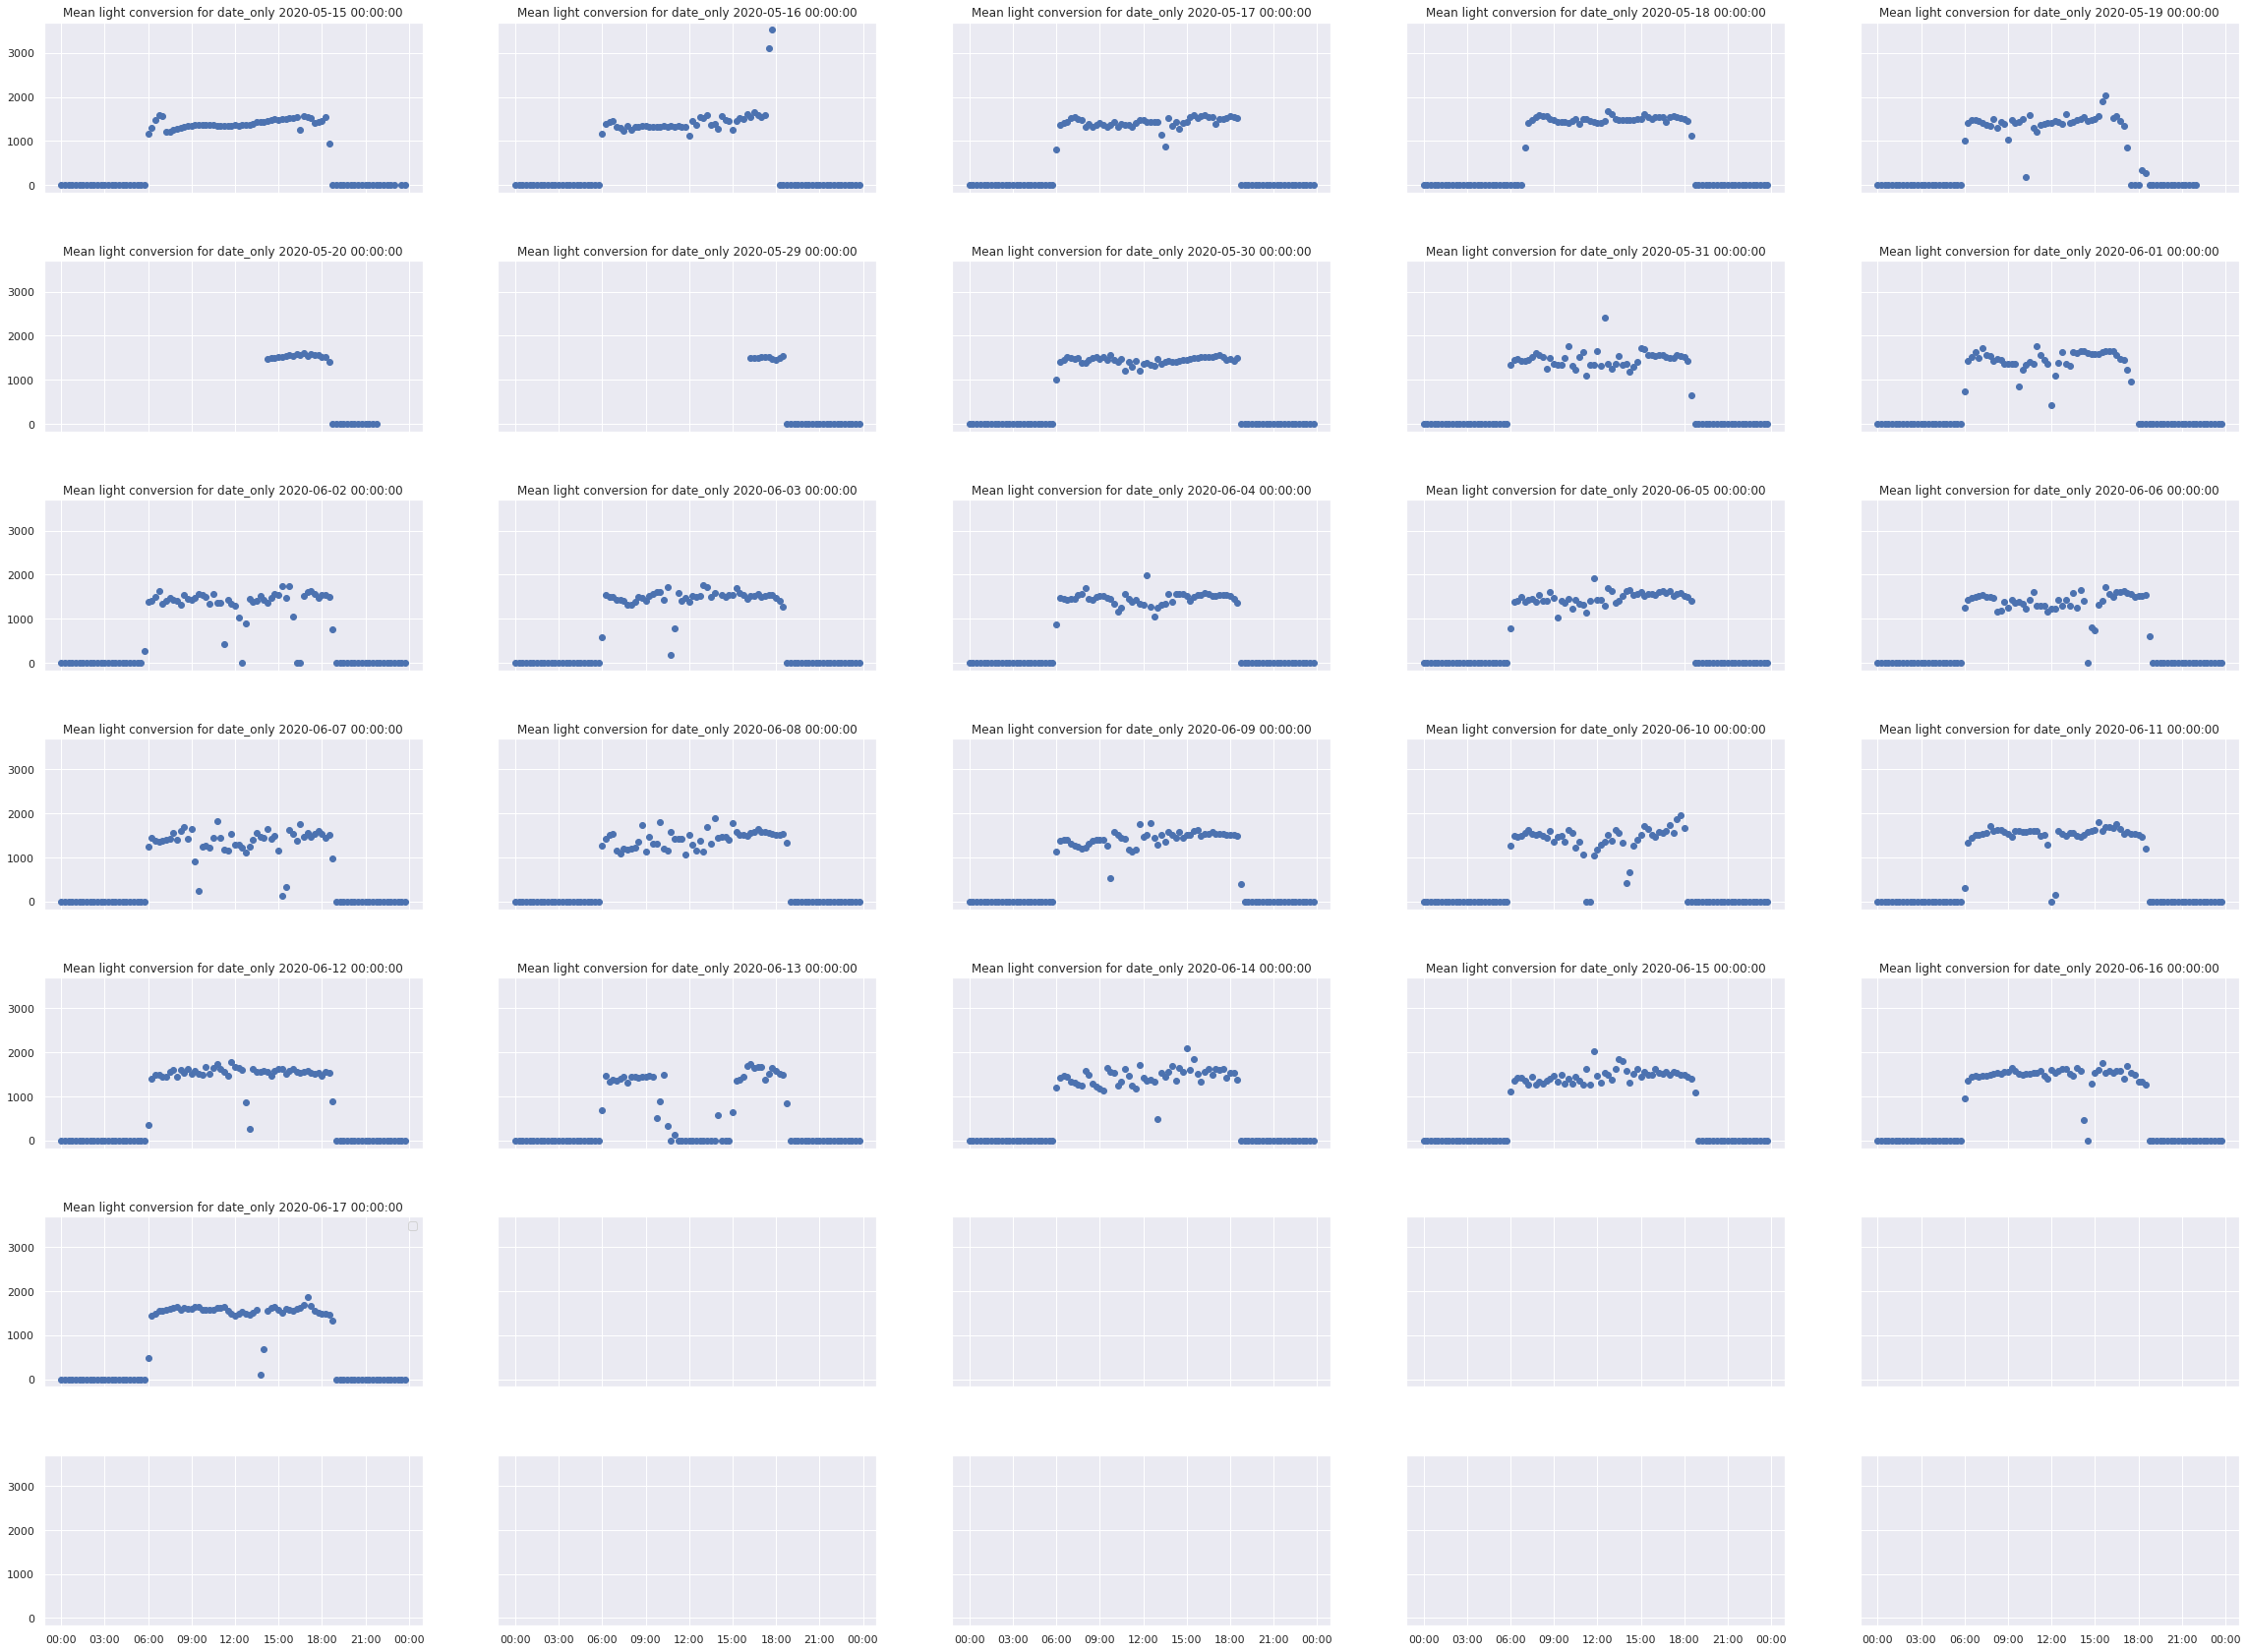

In [52]:
dfPowerMerged_zU1Q = dfPowerMerged[dfPowerMerged['Inverter_ID']=='IQ2d7wF4YD8zU1Q']
subplot_by_col(dfPowerMerged_zU1Q, 
               'date_only', 7, 5, (40,30), 'Mean light conversion for ', 'time_of_day', 'Light_Conversion', xformatter)

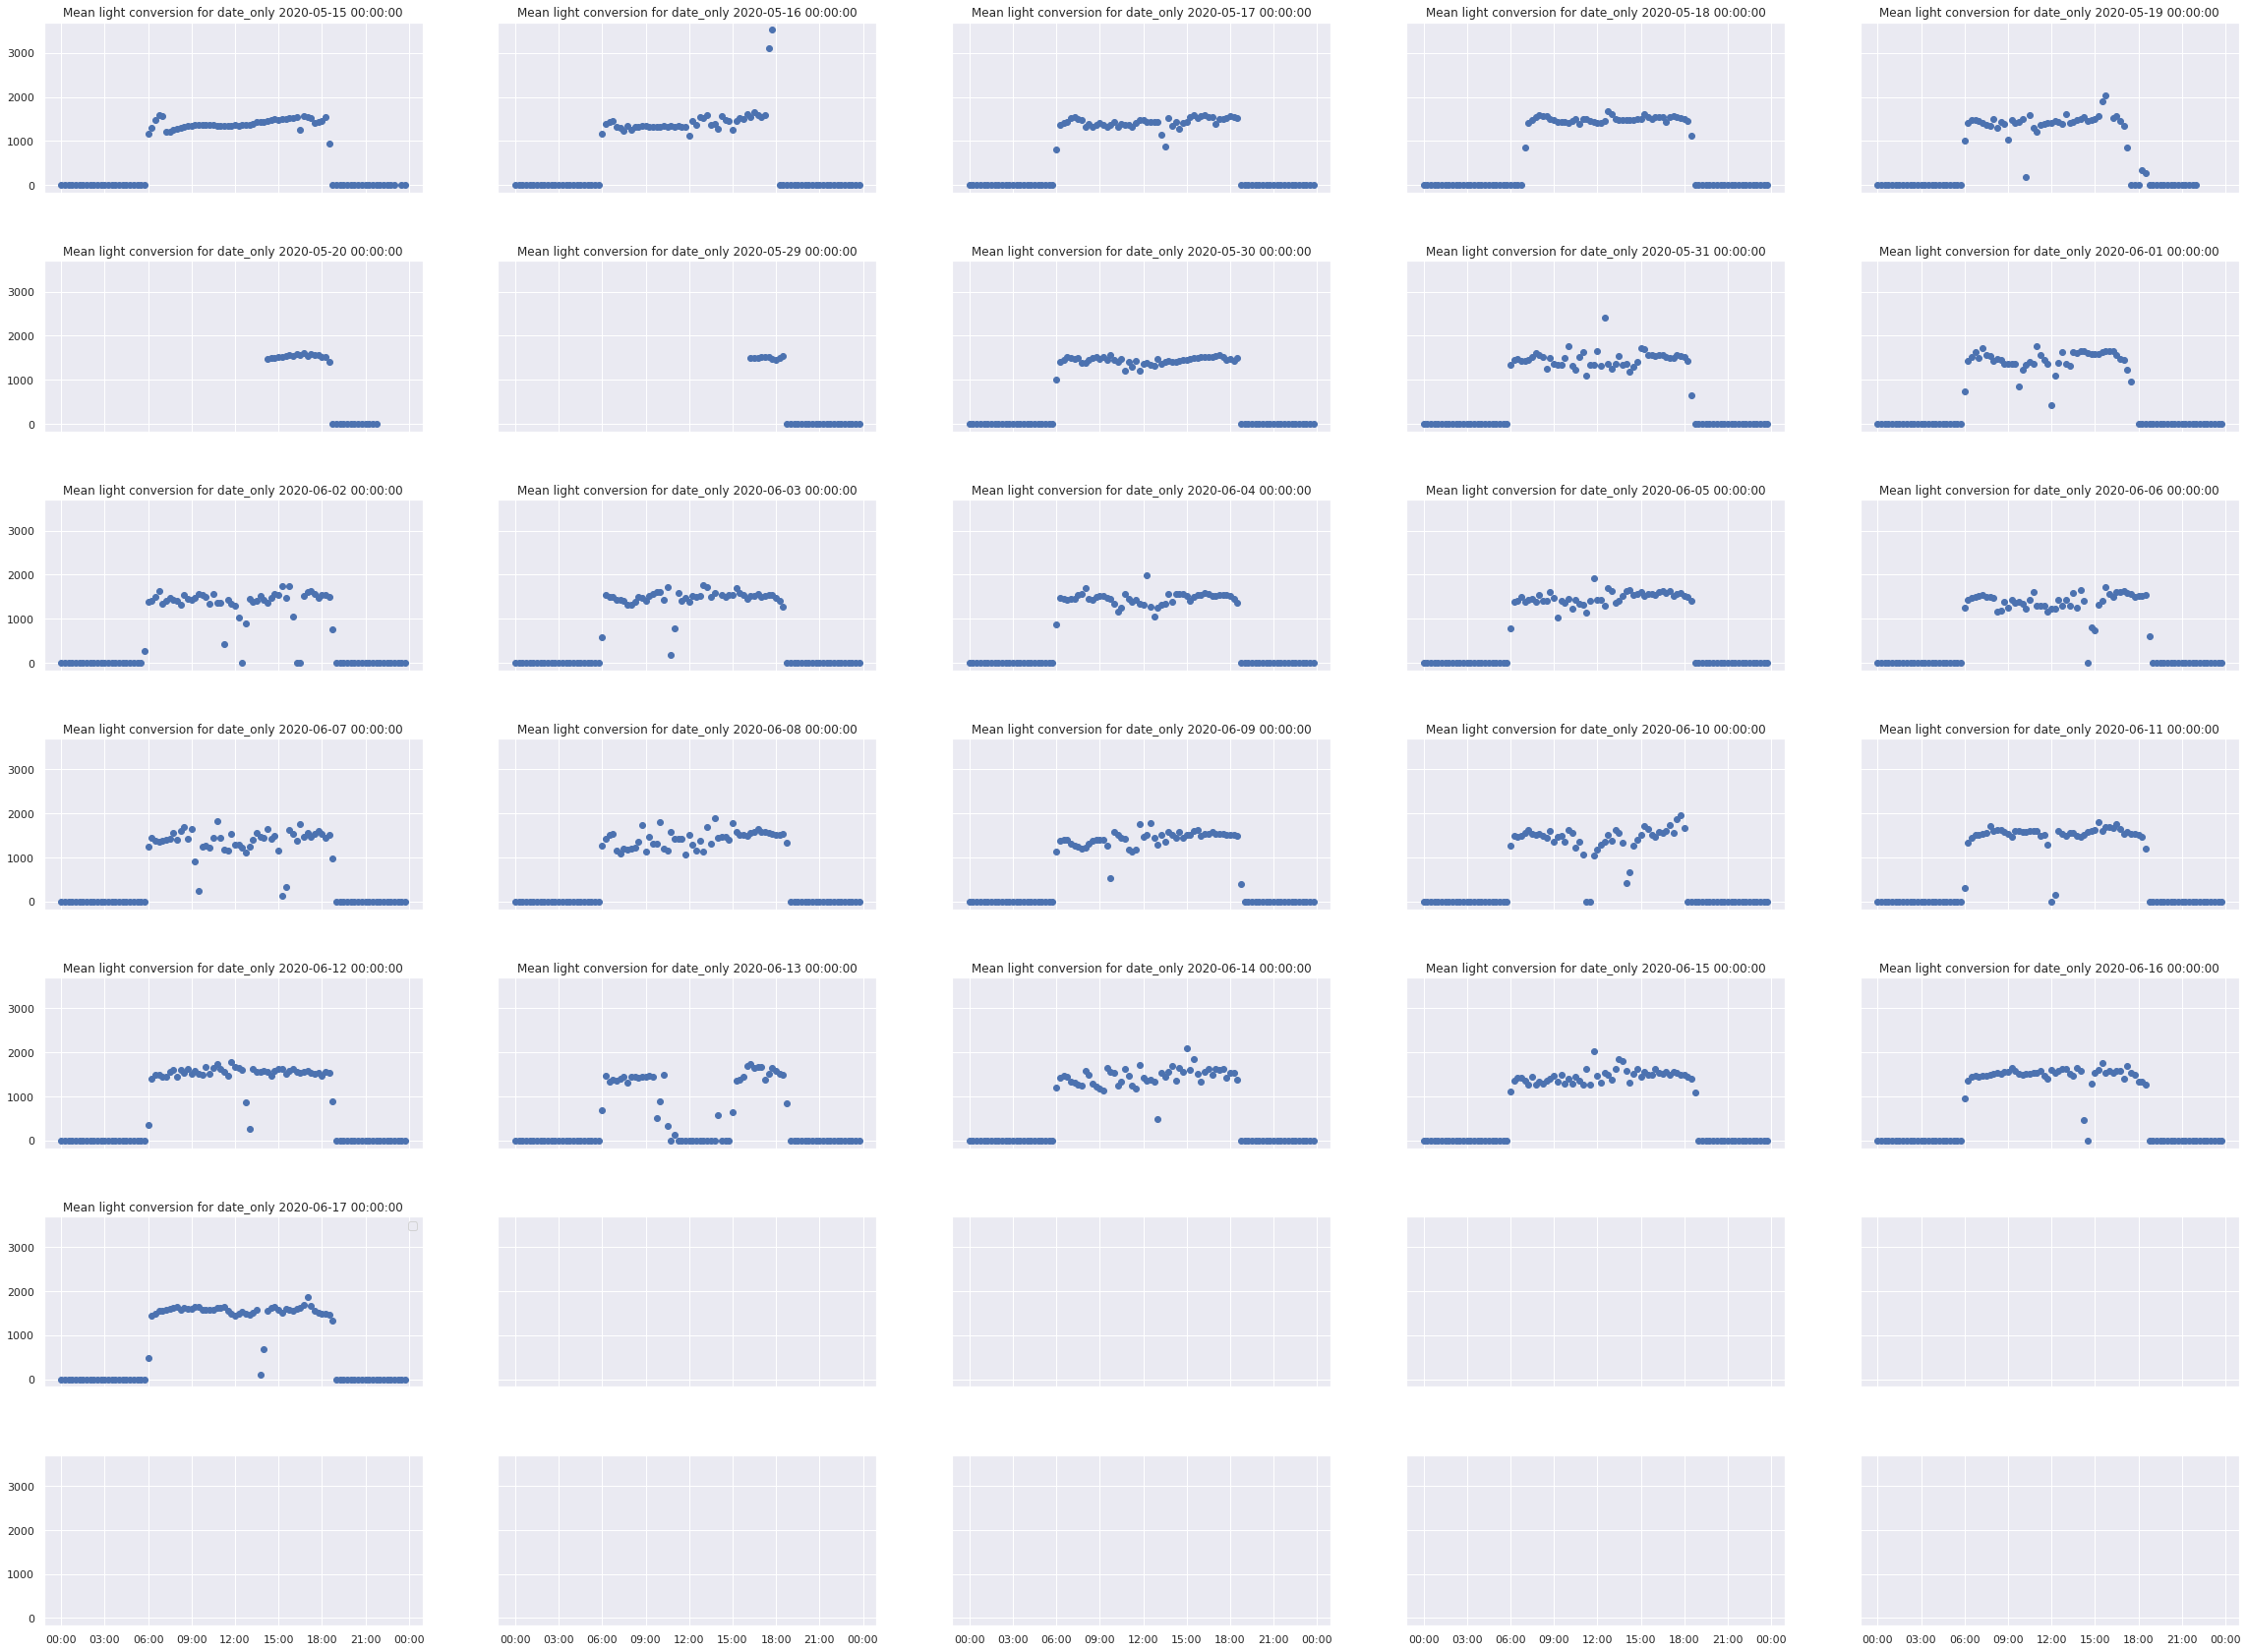

In [53]:
dfPowerMerged_7lBB = dfPowerMerged[dfPowerMerged['Inverter_ID']=='xMbIugepa2P7lBB']
subplot_by_col(dfPowerMerged_zU1Q, 
               'date_only', 7, 5, (40,30), 'Mean light conversion for ', 'time_of_day', 'Light_Conversion', xformatter)

#### Unsupervised Learning to Cluster Inverters by Mean Light Conversion

In [54]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import silhouette_score


In [87]:
dfPowerPeak = dfPowerMergedRemoveShotDown[['Inverter_ID','Light_Conversion','hour']][
    (dfPowerMergedRemoveShotDown['is_peak_hour']==True)&(dfPowerMergedRemoveShotDown['IRRADIATION']>0)].groupby(by=['Inverter_ID','hour']).mean()
dfPowerPeak = dfPowerPeak.reset_index()
dfPowerPeak = dfPowerPeak.pivot(index='Inverter_ID', columns='hour')['Light_Conversion'].dropna(axis=1)
dfPowerPeak

hour,9,10,11,12,13,14,15
Inverter_ID,,,,,,,
4UPUqMRk7TRMgml,1360.819465,1347.860460,1370.273580,1380.128241,1428.062048,1380.316453,1518.780602
81aHJ1q11NBPMrL,1351.748608,1296.688681,1300.373601,1317.375370,1364.648992,1276.523121,1466.811791
9kRcWv60rDACzjR,1328.112739,1307.042598,1308.573668,1327.462657,1346.706747,1347.572303,1461.900176
Et9kgGMDl729KT4,1165.319632,1179.184826,1162.340088,1183.994223,1207.615370,1200.555778,1345.222296
IQ2d7wF4YD8zU1Q,1384.978373,1396.640723,1374.985828,1390.582202,1431.561302,1430.875762,1520.112155
LYwnQax7tkwH5Cb,1285.801777,1231.565288,1271.230009,1197.599548,1297.378662,1253.048304,1420.100869
LlT2YUhhzqhg5Sw,1317.318933,1294.558865,1277.181634,1309.097228,1342.823466,1353.700431,1451.652190
Mx2yZCDsyf6DPfv,1369.951467,1363.292175,1355.296921,1365.298498,1417.745465,1394.778250,1525.795555
NgDl19wMapZy17u,1349.759663,1368.465956,1363.989429,1365.082807,1368.775372,1405.987587,1502.207262


In [88]:
dfPowerNonPeak = dfPowerMergedRemoveShotDown[['Inverter_ID','Light_Conversion','hour']][
    (dfPowerMergedRemoveShotDown['is_peak_hour']==False)&(dfPowerMergedRemoveShotDown['IRRADIATION']>0)].groupby(by=['Inverter_ID','hour']).mean()
dfPowerNonPeak = dfPowerNonPeak.reset_index()
dfPowerNonPeak = dfPowerNonPeak.pivot(index='Inverter_ID', columns='hour')['Light_Conversion'].dropna(axis=1)
dfPowerNonPeak

hour,6,7,8,16,17,18
Inverter_ID,,,,,,
4UPUqMRk7TRMgml,1357.902892,1396.149837,1424.583828,1546.603116,1527.460510,1298.204255
81aHJ1q11NBPMrL,1328.652173,1354.966665,1386.624167,1487.996164,1486.243577,1289.670710
9kRcWv60rDACzjR,1336.409450,1362.284718,1385.857828,1501.545445,1526.006597,1297.113101
Et9kgGMDl729KT4,1216.984711,1244.818673,1259.487384,1372.199025,1384.998729,1204.704891
IQ2d7wF4YD8zU1Q,1326.948587,1421.655388,1442.891224,1554.878663,1567.675602,1359.066825
LYwnQax7tkwH5Cb,1290.245948,1316.290801,1349.664080,1448.887527,1450.537198,1239.278011
LlT2YUhhzqhg5Sw,1325.343827,1347.715312,1375.204163,1484.771539,1501.856113,1284.505436
Mx2yZCDsyf6DPfv,1359.627277,1395.601800,1424.419847,1546.056034,1555.126351,1330.753454
NgDl19wMapZy17u,1290.112667,1400.391744,1423.426101,1530.571349,1535.060090,1339.492820


In [89]:
def test_pre_algo(test_data, algo, num_clus_int, rand_state = None):
  num_clus = range(2, num_clus_int)
  scores = []
  if algo == 'km':
    for i in num_clus:
      km = KMeans(n_clusters = i, random_state=rand_state).fit(test_data)
      labels = km.predict(test_data)
      scores.append(silhouette_score(test_data, labels)) 
  if algo == 'gm':
    for i in num_clus:
      gm = GaussianMixture(n_components=i, random_state=rand_state).fit(test_data)
      labels = gm.predict(test_data)
      scores.append(silhouette_score(test_data, labels))
  if algo == 'ahc':
    for i in num_clus:
      ac=AgglomerativeClustering(n_clusters=i).fit_predict(test_data)
      scores.append(silhouette_score(test_data,ac))  
  if algo == 'mbk':
    for i in num_clus:
      MBK=MiniBatchKMeans(n_clusters=i).fit(test_data)
      labels=MBK.predict(test_data)
      scores.append(silhouette_score(test_data,labels))
  if algo == 'spec':
    for i in num_clus:
      spec=SpectralClustering(n_clusters=i,assign_labels='discretize',random_state=rand_state).fit(test_data)
      labels=spec.labels_
      scores.append(silhouette_score(test_data,labels))
  return scores

In [90]:
import itertools
def rand_state_testing(data, rand_states, algo, num_clus):
  rand_scores = []
  num_clusters = []
  rand_states_list = []
  for rand in rand_states:
     rand_score = test_pre_algo(data, algo, num_clus, rand)
     rand_list = [rand] * len(rand_score)
     rand_scores.append(rand_score)
     num_clusters.append(range(2, num_clus))
     rand_states_list.append(rand_list)
  
  score_res = pd.DataFrame({'rand_states': list(itertools.chain(*rand_states_list)), 
                            'num_clusters': list(itertools.chain(*num_clusters)),
                            'test_scores': list(itertools.chain(*rand_scores))})
  return score_res

In [91]:
def test_all_algo(algoList, data, num_clus, rand=None):
  algoScores = []
  algoListFull = []
  num_clusters = []
  for algo in algoList:
    scores = test_pre_algo(data, algo, num_clus, rand)
    algoScores.append(scores)
    algoListFull.append([algo]*len(scores))
    num_clusters.append(range(2, num_clus))

  score_res = pd.DataFrame({'algorithm': list(itertools.chain(*algoListFull )), 
                            'num_clusters': list(itertools.chain(*num_clusters)),
                            'test_scores': list(itertools.chain(*algoScores))})
  return score_res

From below two graphs, we could see by using K-means the non-peak hour outputs for all inverters could be optimally clustered into 2 groups, and peak hour outputs could be optimally clustered into 2 groups.

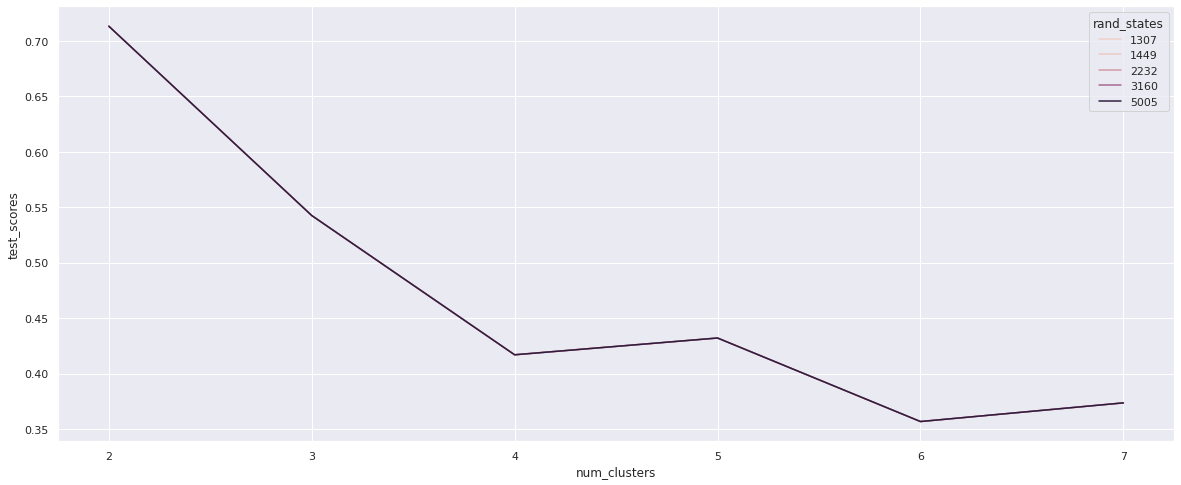

In [92]:
rand_km_res = rand_state_testing(dfPowerNonPeak, np.random.randint(10000, size=5), 'km', 8)
import seaborn as sns
sns.lineplot(data=rand_km_res, x='num_clusters', y='test_scores', hue='rand_states')

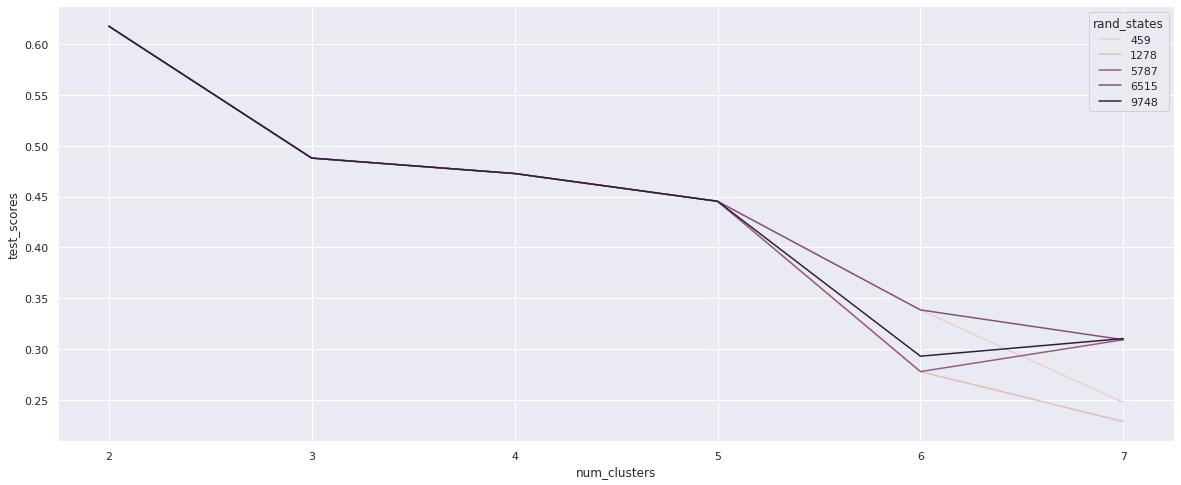

In [93]:
rand_km_res = rand_state_testing(dfPowerPeak, np.random.randint(10000, size=5), 'km', 8)
import seaborn as sns
sns.lineplot(data=rand_km_res, x='num_clusters', y='test_scores', hue='rand_states')

By conducting a few tests with randomized initial randome seeds, Agglomerative Clustering reliably outperformes all other clustering algorithms on the non-peak hour outputs.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expecte

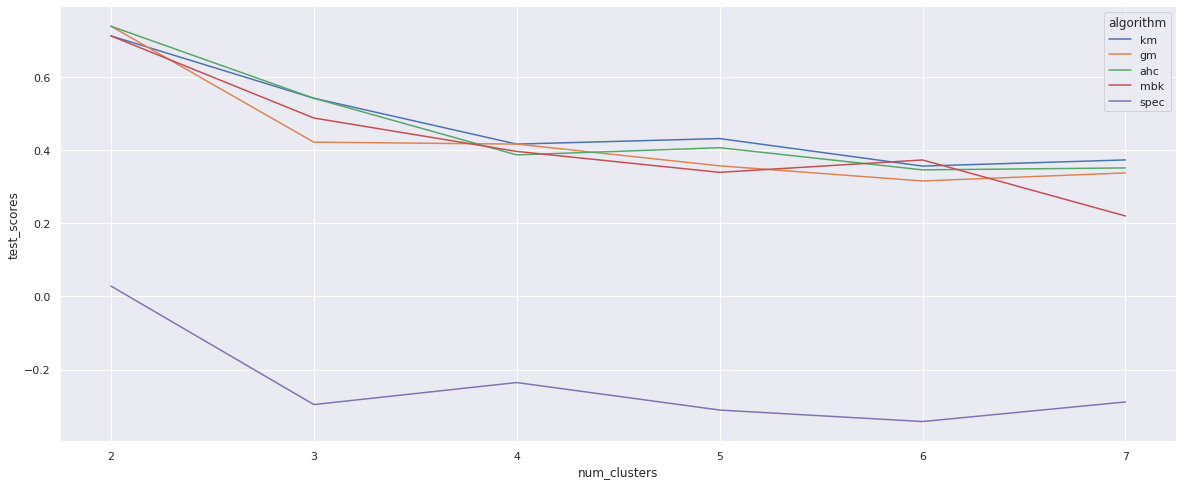

In [97]:
algoRes = test_all_algo(['km', 'gm', 'ahc', 'mbk', 'spec'], dfPowerNonPeak, 8, np.random.randint(10000, size=1)[0])
import seaborn as sns
sns.lineplot(data=algoRes, x='num_clusters', y='test_scores', hue='algorithm')

By conducting a few tests with randomized initial randome seeds, Agglomerative Clustering reliably outperformes all other clustering algorithms on the peak hour outputs.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expecte

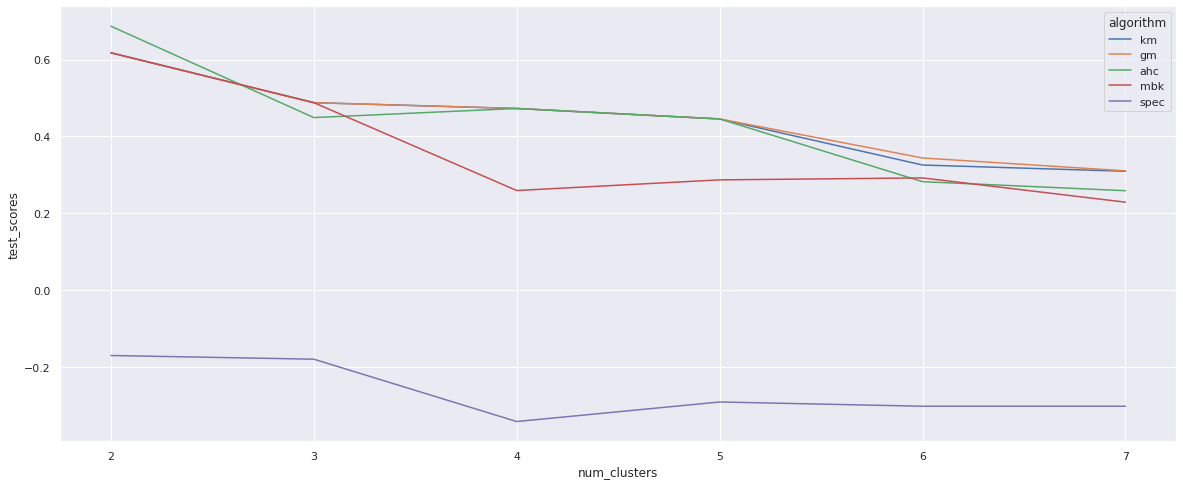

In [103]:
algoRes = test_all_algo(['km', 'gm', 'ahc', 'mbk', 'spec'], dfPowerPeak, 8, np.random.randint(10000, size=1)[0])
import seaborn as sns
sns.lineplot(data=algoRes, x='num_clusters', y='test_scores', hue='algorithm')

In [111]:
ahcNonPeak = AgglomerativeClustering(3).fit(dfPowerNonPeak)
dfPowerNonPeak['cluster_label'] = ahcNonPeak.labels_

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [110]:
dfPowerNonPeak

hour,6,7,8,16,17,18,cluster_label
Inverter_ID,,,,,,,
4UPUqMRk7TRMgml,1357.902892,1396.149837,1424.583828,1546.603116,1527.460510,1298.204255,0
81aHJ1q11NBPMrL,1328.652173,1354.966665,1386.624167,1487.996164,1486.243577,1289.670710,0
9kRcWv60rDACzjR,1336.409450,1362.284718,1385.857828,1501.545445,1526.006597,1297.113101,0
Et9kgGMDl729KT4,1216.984711,1244.818673,1259.487384,1372.199025,1384.998729,1204.704891,2
IQ2d7wF4YD8zU1Q,1326.948587,1421.655388,1442.891224,1554.878663,1567.675602,1359.066825,0
LYwnQax7tkwH5Cb,1290.245948,1316.290801,1349.664080,1448.887527,1450.537198,1239.278011,2
LlT2YUhhzqhg5Sw,1325.343827,1347.715312,1375.204163,1484.771539,1501.856113,1284.505436,0
Mx2yZCDsyf6DPfv,1359.627277,1395.601800,1424.419847,1546.056034,1555.126351,1330.753454,0
NgDl19wMapZy17u,1290.112667,1400.391744,1423.426101,1530.571349,1535.060090,1339.492820,0


In [114]:
ahcPeak = AgglomerativeClustering(3).fit(dfPowerPeak)
dfPowerPeak['cluster_label'] = ahcPeak.labels_

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [115]:
dfPowerPeak

hour,9,10,11,12,13,14,15,cluster_label
Inverter_ID,,,,,,,,
4UPUqMRk7TRMgml,1360.819465,1347.860460,1370.273580,1380.128241,1428.062048,1380.316453,1518.780602,2
81aHJ1q11NBPMrL,1351.748608,1296.688681,1300.373601,1317.375370,1364.648992,1276.523121,1466.811791,0
9kRcWv60rDACzjR,1328.112739,1307.042598,1308.573668,1327.462657,1346.706747,1347.572303,1461.900176,0
Et9kgGMDl729KT4,1165.319632,1179.184826,1162.340088,1183.994223,1207.615370,1200.555778,1345.222296,0
IQ2d7wF4YD8zU1Q,1384.978373,1396.640723,1374.985828,1390.582202,1431.561302,1430.875762,1520.112155,2
LYwnQax7tkwH5Cb,1285.801777,1231.565288,1271.230009,1197.599548,1297.378662,1253.048304,1420.100869,0
LlT2YUhhzqhg5Sw,1317.318933,1294.558865,1277.181634,1309.097228,1342.823466,1353.700431,1451.652190,0
Mx2yZCDsyf6DPfv,1369.951467,1363.292175,1355.296921,1365.298498,1417.745465,1394.778250,1525.795555,2
NgDl19wMapZy17u,1349.759663,1368.465956,1363.989429,1365.082807,1368.775372,1405.987587,1502.207262,2
